# 비선형 시계열 알고리즘

## 상태 공간 모형(State Space Models)

> **"시계열 생성 구조를 관측식(Observation Equation)과 상태 전이식(State Transition Equation) 두 개의 수식으로 정의하는 시계열 모형"**
> - **관측식(Observation Equation)**  
> : 현재의 상태 $x_t$와 잡음(에러) $\upsilon_t$에 의해 실제로 측정가능한 출력 $y_t$를 생성하는 관계식

\begin{align*}
y_t = f(x_t, \upsilon_t)  
\end{align*}

> - **상태 전이식(State Transition Equation)**  
> : 이전의 상태 $x_{t-1}$와 현재 생성된 잡음(에러) $w_t$에 의해 현재의 상태 $x_t$가 생성되는 관계식

\begin{align*}
x_t = g(x_{t-1}, w_t)  
\end{align*}

> - **동적 시스템(Dynamic System)**  
> : 입력 시계열을 받아 출력 시계열을 내놓는 시스템  
> : (예시) ARMA 모형의 경우 백색잡음 $\epsilon_t$를 입력받아 $y_t$를 출력하는 동적 시스템  

> - **상태 변수(State Variable)**  
> : 동적 시스템의 현재 상태를 정의하는 값의 집합  
> : (예시) AR($p$) 모형의 동적시스템은 $p$개의 과거 $Y$값 $\{Y_{t-1}, Y_{t-2}, \cdots, Y_{t-p}\}$이 상태변수  
> : (예시) ARMA($p,q$) 모형의 동적시스템은 $p$개의 과거 $Y$값 $\{Y_{t-1}, Y_{t-2}, \cdots, Y_{t-p}\}$과 $q$개의 과거 $\epsilon$값 $\{\epsilon_{t-1}, \epsilon_{t-2}, \cdots, \epsilon_{t-q}\}$이 상태변수  

\begin{align*}
\text{Equation of AR}(p) && Y_t = \phi_1 Y_{t-1} +  \cdots + \phi_p Y_{t-p} + \epsilon_t
\end{align*}

\begin{align*}
\text{Equation of ARMA}(p,q) && Y_t = \phi_1 Y_{t-1} +  \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1}  \cdots  + \theta_q \epsilon_{t-q} + \epsilon_t
\end{align*}

<center><img src='Image/SSM_Example.png' width='500'></center>

### 지수평활법(Simple Exponential Smoothing)

> **"추세나 계절성 패턴이 없는 경우 적합"**  
> **"미래 시계열 데이터는 과거 특정기간 동안의 평균값이며 그 이전의 값들은 미래에 어떠한 정보도 주지 않는다"**  

\begin{align*}
\hat{Y}_{t+1} & = \dfrac{1}{T}\displaystyle \sum_{i=0}^{T} Y_{t-i} \\ & or \\
\hat{Y}_{t+1} & = \dfrac{\alpha}{T}\displaystyle \sum_{i=1}^{T} (1-\alpha)^i Y_{t-i} \\
\end{align*}

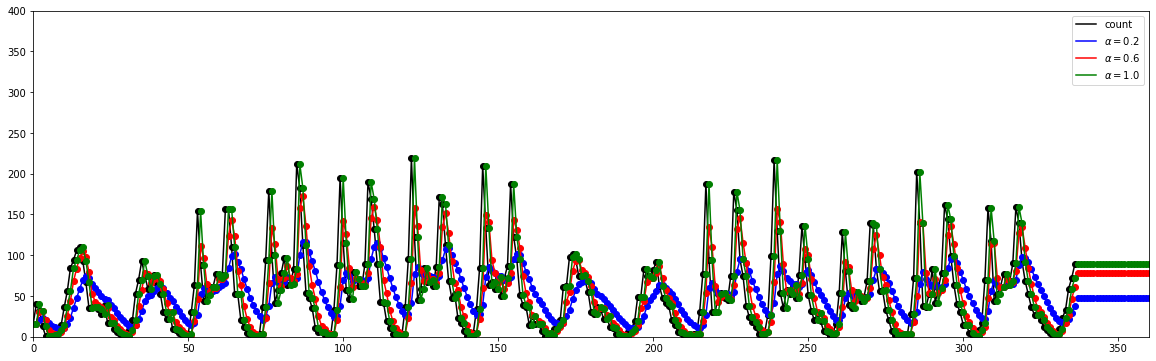

In [2]:
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
import matplotlib.pyplot as plt

location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Simple Exponential Smoothing
target = raw_all.loc[:24*7*2, 'count']
target.plot(marker='o', color='black', legend=True, figsize=(20,6), ylim=(0,400))

fit1 = SimpleExpSmoothing(target).fit(smoothing_level=0.2, optimized=False)
fcast1 = fit1.forecast(24).rename(r'$\alpha=0.2$')
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')

fit2 = SimpleExpSmoothing(target).fit(smoothing_level=0.6, optimized=False)
fcast2 = fit2.forecast(24).rename(r'$\alpha=0.6$')
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')

fit3 = SimpleExpSmoothing(target).fit()
fcast3 = fit3.forecast(24).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.show()

### 선형 추세 알고리즘 by Holt

> **"간단 지수평활법에 추세를 반영한 예측 알고리즘"**  

\begin{align*}
\text{Main equation}  && \hat{Y}_{t+h} &= \ell_{t} + hb_{t} \\
\text{Level equation} && \ell_{t} &= \alpha Y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1}) \\
\text{Trend equation} && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1}  
\end{align*}

\begin{align*}
where~0 \leq \beta^* \leq 1~is~the~smoothing~parameter~for~the~trend
\end{align*}

| Year | $t$ | $Y_t$ | $ℓ_t$ | $b_t$ | $\hat{Y_t}$ |
|------|---|-------|-------|------|-------|
| 2014 | 0 |  | 17.55 | 4.31 |  |
| 2015 | 1 | 17.55 | 18.41 | 3.62 | 21.86 |
| 2016 | 2 | 21.86 | 21.89 | 3.59 | 22.03 |
| 2017 | 3 | 23.89 | 24.21 | 3.33 | 25.48 |
| 2018 | 4 | 26.93 | 27.05 | 3.24 | 27.54 |

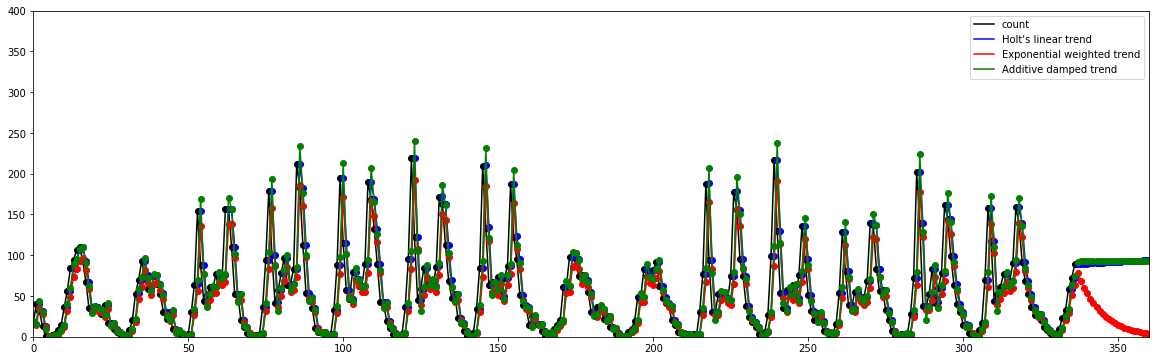

In [3]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt

location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Holt's Linear Trend
target = raw_all.loc[:24*7*2, 'count']
target.plot(marker='o', color='black', legend=True, figsize=(20,6), ylim=(0,400))

fit1 = Holt(target).fit()
fcast1 = fit1.forecast(24).rename("Holt's linear trend")
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')

fit2 = Holt(target, exponential=True).fit()
fcast2 = fit2.forecast(24).rename("Exponential weighted trend")
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')

fit3 = Holt(target, damped=True).fit()
fcast3 = fit3.forecast(24).rename("Additive damped trend")
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.show()

### 계절 알고리즘 by Holt-Winter

> **"선형 추세 알고리즘에 계절성을 반영한 예측 알고리즘"**  

- **Additive Seasonal Method:** $Y_t = T_t + S_t + R_t$, 계절성 변화의 크기가 시간 흐름에 따라 일정한 경우 선호

\begin{align*}
\text{Main equation}     && \hat{Y}_{t+h} &= \ell_{t} + hb_{t} + s_{t-m+h_{m}^{+}} \\
\text{Level equation}    && \ell_{t} &= \alpha(Y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1}) \\
\text{Trend equation}    && b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1} \\
\text{Seasonal equation} && s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m} \\
\end{align*}

\begin{align*}
where~h_{m}^{+} = \lfloor(h-1)/m\rfloor+1~ensures~that~estimates~of~the~sesonal~indices~come~from~the~final~year~of~the~sample \\
\end{align*}

- **Multiplicative Seasonal Method:** $Y_t = T_t \times S_t \times R_t$, 계절성 변화의 크기가 시간 흐름에 비례하여 변경되는 경우 선호

\begin{align*}
\text{Main equation}     && \hat{Y}_{t+h} &= (\ell_{t} + hb_{t})s_{t-m+h_{m}^{+}} \\
\text{Level equation}    && \ell_{t} &= \alpha \frac{Y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1}) \\
\text{Trend equation}    && b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1} \\
\text{Seasonal equation} && s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m} \\
\end{align*}

- **Damped Seasonal Method:** Additive와 Multiplicative 모두 사용되며 장기 예측시 무한정 증가/감소를 방지

\begin{align*}
\text{Main equation}     && \hat{Y}_{t+h} &= \left[\ell_{t} + (\phi+\phi^2 + \dots + \phi^{h})b_{t}\right]s_{t+h-m(k+1)} \\
\text{Level equation}    && \ell_{t} &= \alpha(y_{t} / s_{t-m}) + (1 - \alpha)(\ell_{t-1} + \phi b_{t-1}) \\
\text{Trend equation}    && b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)\phi b_{t-1} \\
\text{Seasonal equation} && s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + \phi b_{t-1})} + (1 - \gamma)s_{t-m} \\
\end{align*}

> **Summary of Smoothing Parameters:**

| Level | Trend | Seasonality | Damping |
|----------|---------|-------------|---------|
| $\alpha$ | $\beta$ | $\gamma$ | $\phi$ |



- **Example of Estimation Process:**


| - | $t$ | $Y_t$ | $\ell_t$ | $b_t$ | $s_t$ | $\hat{Y}_t$ |
|---------|-------|-------|-------|-------|-------------|-----------------|
| 2004 Q1 | -3 | - | - | - | 1.24 | - |
| 2004 Q2 | -2 | - | - | - | 0.77 | - |
| 2004 Q3 | -1 | - | - | - | 0.96 | - |
| 2004 Q4 | 0 | - | 32.49 | 0.7 | 1.02 | - |
| 2005 Q1 | 1 | 42.21 | 33.51 | 0.71 | 1.24 | 41.29 |
| 2005 Q2 | 2 | 24.65 | 33.24 | 0.68 | 0.77 | 26.36 |
| 2005 Q3 | 3 | 32.67 | 33.94 | 0.68 | 0.96 | 32.62 |
| 2005 Q4 | 4 | 37.26 | 35.4 | 0.7 | 1.02 | 35.44 |
| - | ⋮ | ⋮ | ⋮ | ⋮ | ⋮ | ⋮ |
| 2015 Q1 | 41 | 73.26 | 58.57 | 0.66 | 1.24 | 72.59 |
| 2015 Q2 | 42 | 47.7 | 60.42 | 0.69 | 0.77 | 45.62 |
| 2015 Q3 | 43 | 61.1 | 62.17 | 0.72 | 0.96 | 58.77 |
| 2015 Q4 | 44 | 66.06 | 63.62 | 0.75 | 1.02 | 64.38 |
| - | $h$ | - | - | - | - | $\hat{Y}_{T+h}$ |
| 2016 Q1 | 1 | - | - | - | - | 80.09 |
| 2016 Q2 | 2 | - | - | - | - | 50.15 |
| 2016 Q3 | 3 | - | - | - | - | 63.34 |
| 2016 Q4 | 4 | - | - | - | - | 68.18 |
| 2017 Q1 | 5 | - | - | - | - | 83.8 |
| 2017 Q2 | 6 | - | - | - | - | 52.45 |
| 2017 Q3 | 7 | - | - | - | - | 66.21 |
| 2017 Q4 | 8 | - | - | - | - | 71.23 |


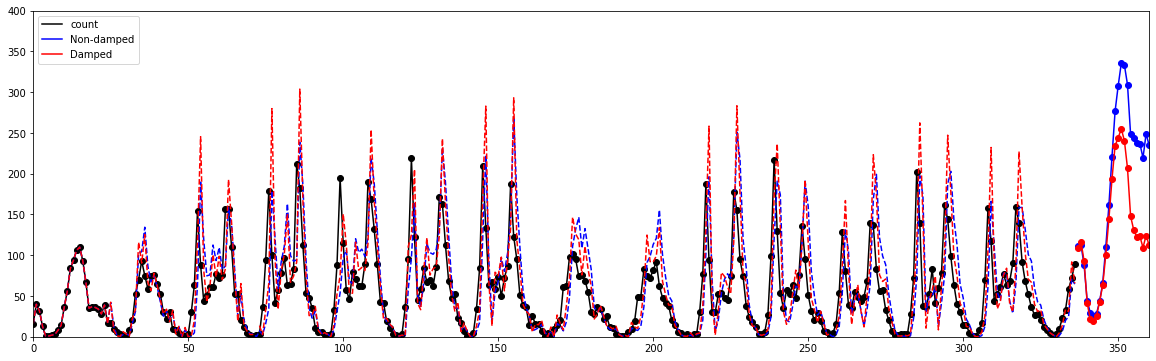

In [4]:
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt

location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Holt-Winter's Seasonal
target = raw_all.loc[:24*7*2, 'count']
target.plot(marker='o', color='black', legend=True, figsize=(20,6), ylim=(0,400))

fit1 = ExponentialSmoothing(target, seasonal_periods=24, trend='add', seasonal='add').fit(use_boxcox=True)
fcast1 = fit1.forecast(24).rename("Non-damped")
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(style='--', color='blue')

fit2 = ExponentialSmoothing(target, seasonal_periods=24, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fcast2 = fit2.forecast(24).rename("Damped")
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(style='--',  color='red')

plt.show()

### 지수평활법 알고리즘 분류 요약

- **알고리즘 옵션 분류**

| Trend Component | Seasonal Component | - | - |
|-------------------------|--------------------|------------|------------------|
| - | N | A | M |
| - | (None) | (Additive) | (Multiplicative) |
| N (None) | (N,N) | (N,A) | (N,M) |
| A (Additive) | (A,N) | (A,A) | (A,M) |
| $A_d$ (Additive damped) | ($A_d$,N) | ($A_d$,A) | ($A_d$,M) |

- **각 분류별 알고리즘**

| Short hand | Method |
|------------|-------------------------------------|
| (N,N) | Simple exponential smoothing |
| (A,N) | Holt’s linear method |
| ($A_d$,N) | Additive damped trend method |
| (A,A) | Additive Holt-Winters’ method |
| (A,M) | Multiplicative Holt-Winters’ method |
| ($A_d$,M) | Holt-Winters’ damped method |

<center><img src='Image/TS_ExponentialSmoothing.png' width='800'></center> 

### ETS(Error/Trend/Seasonal) 알고리즘

**1) ETS(A,N,N): simple exponential smoothing with additive errors**  
**2) ETS(M,N,N): simple exponential smoothing with multiplicative errors**  
**3) ETS(A,A,N): Holt’s linear method with additive errors**  
**4) ETS(M,A,N): Holt’s linear method with multiplicative errors**  

<center><img src='Image/TS_ETS_Equation.png' width='800'></center> 

<center><img src='Image/TS_ETS_Figure.png' width='600'></center> 


| Model 	| Forecast variance: $\sigma_h^2$ 	|
|-------------	|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| (A,N,N) 	| $\sigma_h^2 = \sigma^2\big[1 + \alpha^2(h-1)\big]$ 	|
| (A,A,N) 	| $\sigma_h^2 = \sigma^2\Big[1 + (h-1)\big\{\alpha^2 + \alpha\beta h + \frac16\beta^2h(2h-1)\big\}\Big]$ 	|
| (A,$A_d$,N) 	| $\sigma_h^2 = \sigma^2\biggl[1 + \alpha^2(h-1) + \frac{\beta\phi h}{(1-\phi)^2} \left\{2\alpha(1-\phi) +\beta\phi\right\} \\ \mbox{} - \frac{\beta\phi(1-\phi^h)}{(1-\phi)^2(1-\phi^2)} \left\{ 2\alpha(1-\phi^2)+ \beta\phi(1+2\phi-\phi^h)\right\}\biggr]$ 	|
| (A,N,A) 	| $\sigma_h^2 = \sigma^2\Big[1 + \alpha^2(h-1) + \gamma k(2\alpha+\gamma)\Big]$ 	|
| (A,A,A) 	| $\sigma_h^2 = \sigma^2\Big[1 + (h-1)\big\{\alpha^2 + \alpha\beta h + \frac16\beta^2h(2h-1)\big\} \\ \mbox{} + \gamma k \big\{2\alpha+ \gamma + \beta m (k+1)\big\} \Big]$ 	|
| (A,$A_d$,A) 	| $\sigma_h^2 = \sigma^2\biggl[1 + \alpha^2(h-1) + \gamma k(2\alpha+\gamma) \\ \mbox{} +\frac{\beta\phi h}{(1-\phi)^2} \left\{2\alpha(1-\phi) + \beta\phi \right\} \\ \mbox{} - \frac{\beta\phi(1-\phi^h)}{(1-\phi)^2(1-\phi^2)} \left\{ 2\alpha(1-\phi^2)+ \beta\phi(1+2\phi-\phi^h)\right\} \\ \mbox{} + \frac{2\beta\gamma\phi}{(1-\phi)(1-\phi^m)}\left\{k(1-\phi^m) - \phi^m(1-\phi^{mk})\right\}\biggr]$ 	|

### 상태공간 모형과 ARIMA 모형의 관계

> **동적 선형모형(Dynamics Linear Model) vs. ARIMA 모형**
> - 모든 ARIMA 모형은 동일한 출력(Measurement)을 가지는 동적 선형 모형으로 표현가능하며, 조합 방법은 무한함
> - 모든 동적 선형모형 출력은 ARIMA 모형으로 표현 가능

- **상태공간모형 $\Longrightarrow$ ARMA**

\begin{align*}
\text{Main Equation of State Space Model} && Y_{t} &= A_t X_{t} =  A_t (I- \Phi_t L)^{-1} w_t \\
\text{where} && X_{t} &= \Phi_t X_{t-1} + w_t \\
&& &= \Phi_t L X_{t} + w_t \\
&& (I- \Phi_t L) X_{t} &=  w_t \\
&& X_{t} &=  (I- \Phi_t L)^{-1} w_t \\
\end{align*}

- **ARMA(p,q) $\Longrightarrow$ 상태공간모형** : 상태변수를 정하는 방법이 무한하기에 표준형식(Canonical Form)을 따름

\begin{align*}
\text{Main Equation of ARMA(p,q)} && Y_t &= \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \cdots + \theta_q e_{t-q} \\
\text{let $r=max(p,q+1)$} && Y_{t} &= \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_r Y_{t-r} + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \cdots + \theta_{r-1} e_{t-(r-1)} \\
\text{Insert State Space} && Y_t &=
\begin{bmatrix} 1 & 0 & \cdots & 0 \end{bmatrix}
\begin{bmatrix}
x_{t,1} \\ x_{t,2} \\ \vdots  \\ x_{t,r-1} \\ x_{t,r} \\
\end{bmatrix} \\
\text{where} && x_{1,t} &= \phi_1 x_{1,t-1} + x_{2,t-1} + e_t \\
&& x_{2,t} &= \phi_2 x_{1,t-1} + x_{3,t-1} + \theta_1 e_t \\
&& x_{3,t} &= \phi_3 x_{1,t-1} + x_{4,t-1} + \theta_2 e_t \\
&& & \vdots \\
&& x_{r-1,t} &= \phi_{r-1} x_{1,t-1} + x_{r,t-1} + \theta_{r-2} e_t \\
&& x_{r,t} &= \phi_{r} x_{1,t-1} + \theta_{r-1} e_t \\
\text{Induced} && x_{1,t} &= \phi_1 x_{1,t-1} + \phi_2 x_{1,t-2} + \cdots + \phi_r x_{1,t-r} + e_t +  \theta_1 e_t + \cdots + \theta_{r-1} e_{t-(r-1)} \\
\text{State Space Form} && Y_t &=
\begin{bmatrix} 1 & 0 & \cdots & 0 \end{bmatrix}
\begin{bmatrix}
x_{t,1} \\ x_{t,2} \\ \vdots  \\ x_{t,r-1} \\ x_{t,r} \\
\end{bmatrix} \\
\text{where} &&
\begin{bmatrix}
x_{t,1} \\ x_{t,2} \\ \vdots  \\ x_{t,r-1} \\ x_{t,r} \\
\end{bmatrix}
&= \begin{bmatrix}
\phi_1     &      1 &      0 & \cdots &      0 \\
\phi_2     &      0 &      1 & \cdots &      0 \\
\vdots     & \vdots & \vdots & \ddots & \vdots \\
\phi_{r-1} &      0 &      1 & \cdots &      1 \\
\phi_r     &      0 &      0 & \cdots &      0 \\
\end{bmatrix}
\begin{bmatrix}
x_{t-1,1} \\ x_{t-1,2} \\ \vdots  \\ x_{t-1,r-1} \\ x_{t-1,r} \\
\end{bmatrix}
+
\begin{bmatrix}
1 & \theta_1 & \cdots & \theta_{r-1}
\end{bmatrix}
\begin{bmatrix}
e_{1} \\ e_{2} \\ \vdots  \\ e_{r-1} \\ e_{r} \\
\end{bmatrix}
\end{align*}

- **ARIMA(p,d,q) $\Longrightarrow$ 상태공간모형** : $\Delta^d Y_t = ARMA(p,q)$

\begin{align*}
\text{Each Equation of $\Delta^d Y_t$} && \Delta^{1} Y_{t} &= Y_t - Y_{t-1} \\
&& \Delta^{2} Y_{t} &= \Delta^{1} Y_{t}- \Delta^{1} Y_{t-1} \\
&& & \vdots \\
&& \Delta^{d} Y_{t} &= \Delta^{d-1} Y_{t}- \Delta^{d-1} Y_{t-1} \\
\text{State Space Form} && Y_t &=
\begin{bmatrix} 1 & 1 & \cdots & 1 & 1 & 0 & \cdots & 0 \end{bmatrix}
\begin{bmatrix}
Y_{t} \\ \Delta Y_{t-1} \\ \vdots  \\ \Delta^{d-1} Y_{t-1} \\ \Delta^{d} Y_{t-1} \\
x_{t,2} \\ \vdots  \\ x_{t,r-1} \\ x_{t,r} \\ \end{bmatrix} \\
\text{where} &&
\begin{bmatrix}
Y_{t-1} \\ \Delta Y_{t-1} \\ \vdots  \\ \Delta^{d-1} Y_{t-1} \\ \Delta^{d} Y_{t} \\
x_{t,2} \\ \vdots  \\ x_{t,r-1} \\ x_{t,r} \\
\end{bmatrix}
&= \begin{bmatrix}
1      &      1 & \cdots &      1 &          1 &      0 &      0 &\cdots &      0 \\
0      &      1 & \cdots &      1 &          1 &      0 &      0 &\cdots &      0 \\
\vdots & \vdots & \vdots & \vdots &     \vdots &      0 &      0 &\cdots &      0 \\
0      &      0 & \cdots &      1 &          1 &      0 &      0 & \cdots &      0 \\
0      &      0 & \cdots &      0 &     \phi_1 &      1 &      0 & \cdots &      0 \\
0      &      0 & \cdots &      0 &     \phi_2 &      0 &      1 & \cdots &      0 \\
0      &      0 & \cdots &      0 &     \vdots & \vdots & \vdots & \ddots & \vdots \\
0      &      0 & \cdots &      0 & \phi_{r-1} &      0 &      1 & \cdots &      1 \\
0      &      0 & \cdots &      0 &     \phi_r &      0 &      0 & \cdots &      0 \\
\end{bmatrix}
\begin{bmatrix}
Y_{t-2} \\ \Delta Y_{t-2} \\ \vdots  \\ \Delta^{d-1} Y_{t-2} \\ \Delta^{d} Y_{t-1} \\ x_{t-1,2} \\
\vdots  \\ x_{t-1,r-1} \\ x_{t-1,r} \\
\end{bmatrix} \\
&& &+
\begin{bmatrix}
0 & \cdots & 0 & 1 & \theta_1 & \cdots & \theta_{r-1}
\end{bmatrix}
\begin{bmatrix}
0 \\ 0 \\ \vdots  \\ 0 \\ e_{1} \\ e_{2} \\ \vdots  \\ e_{r-1} \\ e_{r} \\
\end{bmatrix}
\end{align*}

#### 로컬레벨 모형(Local Level Model)

> 랜덤워크 모형에 관측잡음이 추가된 것으로 랜덤워크 과정을 따르는 단변수 상태변수 $\mu_t$를 가짐
\begin{align*}
\mu_t &= \mu_{t-1} + w_t &,\;\;\; & w_t \sim N(0, \sigma_w^2) \\
Y_{t} &= \mu_{t} + v_t &,\;\;\; & v_t \sim {N}(0, \sigma_v^2) \\
\end{align*}

- **로컬레벨 모형 $\Longrightarrow$ ARIMA 모형**

> **로컬레벨 모형은 ARIMA(0,1,1)의 다른표현**
> - $\Delta Y_t$는 $MA(1)$ 모형을 따르고 $Y_t$는 $ARIMA(0,1,1)$ 모형을 따름

\begin{align*}
\text{Setting of $\mu_t$} && \mu_t &= Y_t - v_t \\
\text{Equation of Local Level Model} && Y_t - v_t &= Y_{t-1} - v_{t-1} + w_t \\
\text{Equation of ARIMA Model} && \Delta Y_t &= Y_t - Y_{t-1} = w_t + v_t - v_{t-1} \\
\text{Expectation} && \text{E} \left( \Delta Y_t \right) &= \text{E} \left( w_t + v_t - v_{t-1} \right) =0 \\
\text{Variance} && \text{E} ( \Delta Y_t^2 ) &= \text{E} \left[ (w_t + v_t - v_{t-1})(w_{t} + v_{t} - v_{t-1}) \right] \\
&& &= \text{E} \left( w_t^2 + v_t^2 + v_{t-1}^2 \right) \\
&& &= \sigma_w^2 + 2\sigma_v^2 \\
\text{Autocorrelation(1)} && \text{E} ( \Delta Y_t \Delta Y_{t-1} ) &= \text{E} \left[ (w_t + v_t - v_{t-1})(w_{t-1} + v_{t-1} - v_{t-2}) \right] \\
&& &= - \text{E} \left( v_{t-1}^2 \right) \\
&& &= -\sigma_v^2 \\
\text{Autocorrelation($l$)} && \text{E} ( \Delta Y_t \Delta Y_{t-l} ) &= 0, \;\;\; \text{for } l > 1
\end{align*}

- **ARIMA 모형과의 차이점:**
> **ARIMA(0,1,1)이 아닌 로컬 레벨 모형을 사용하는 이유는 다음과 같이 이유와 가정 때문**
> - 우리가 관심을 가지는 값은 어떤 이유에 의해 반드시 랜덤 워크 모형을 따라야 한다.
> - 그런데 시계열 자료 $Y_t$는 랜덤 워크 모형을 따르지 않는다. (ARIMA(0,1,1) 모형을 따름)
> - 그러므로 시계열 자료 $Y_t$는 우리가 원하는 랜덤 워크 $\mu_t$에 관측 잡음이 더해진 걸로 가정하자.
> - 이제 변경된 풀어야 하는 문제는 시계열 자료 $Y_t$를 사용하여 랜덤 워크 모형을 따르는, 잡음을 제거한 원래의 값 $\mu_t$이다.

- **예시문제1:**  
    1) 어떤 섬 근처에서 배가 엔진을 끄고 정지해 있다.  
    2) 이 배는 파도에 의한 브라운 운동(Brown montion)을 하게 된다.  
    3) 파도의 랜덤한 힘에 밀려 배의 위치는 다음과 같은 수식으로 변화된다.  
    \begin{align*}
    \mu_t = \mu_{t-1} + w_t
    \end{align*}  
    4) 매 시간마다 배의 선원은 섬으로부터의 거리 $Y_t$를 배에 있는 초음파 거리계(ultrasonic range finder)로 측정한다.  
    5) 이러한 경우에 정확한 거리 $\mu_t$를 알고자 하는 것이 바로 로컬 레벨 모형의 필터링(filtering) 문제가 된다.  

- **예시문제2:**  
    1) 효율적인 시장에서 거래되는 주식의 가격, 즉 주가는 일반적으로 랜덤 워크를 따르는 것으로 생각할 수 있다.  
    2) 시장 미시구조 잡음이 있는 주가로부터 근본적인 주식의 내재 가치 즉, 랜덤 워크를 따르는 가치를 추정하고자 하는 경우도 로컬 레벨 모형의 필터링 문제로 볼 수 있다.    

#### 실습: 로컬레벨 모형 데이터생성 및 이해

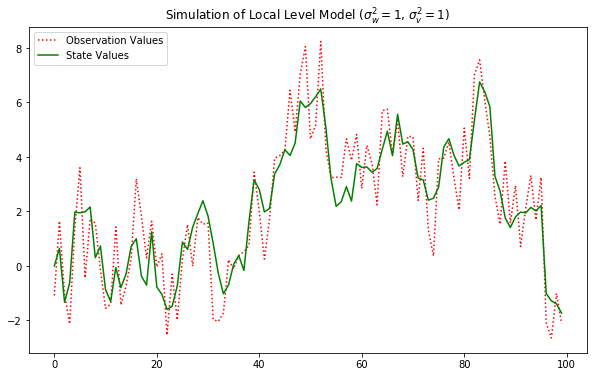

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

# 데이터 생성
np.random.seed(123)
model_generator = KalmanFilter(k_endog=1, k_states=1,
                               transition=[[1]], selection=[[1]], state_cov=[[1]],
                               design=[[1]], obs_cov=[[1]])
y_gener, x_gener = model_generator.simulate(100)

# 데이터 생성
plt.figure(figsize=(10,6))
plt.plot(y_gener, 'r:', label="Observation Values")
plt.plot(x_gener, 'g-', label="State Values")
plt.legend()
plt.title("Simulation of Local Level Model ($\sigma_w^2 = 1$, $\sigma_v^2 = 1$)")
plt.show()

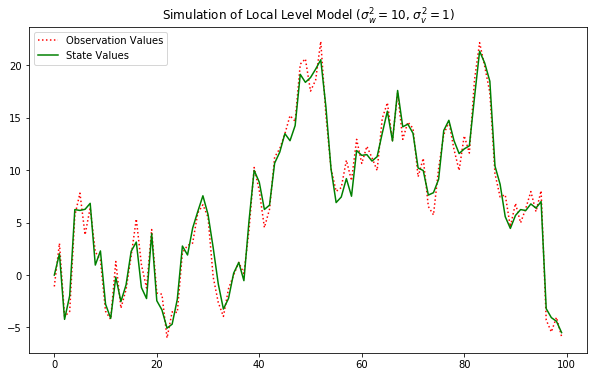

In [6]:
# 데이터 생성
np.random.seed(123)
model_generator = KalmanFilter(k_endog=1, k_states=1,
                               transition=[[1]], selection=[[1]], state_cov=[[10]],
                               design=[[1]], obs_cov=[[1]])
y_gener, x_gener = model_generator.simulate(100)

# 데이터 생성
plt.figure(figsize=(10,6))
plt.plot(y_gener, 'r:', label="Observation Values")
plt.plot(x_gener, 'g-', label="State Values")
plt.legend()
plt.title("Simulation of Local Level Model ($\sigma_w^2 = 10$, $\sigma_v^2 = 1$)")
plt.show()

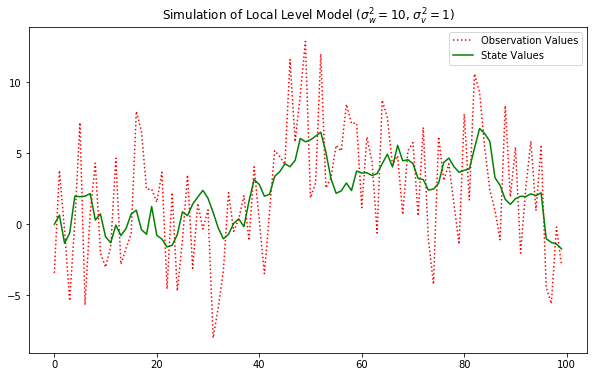

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -279.818
Date:                Fri, 13 Mar 2020   AIC                            563.636
Time:                        23:32:03   BIC                            568.827
Sample:                             0   HQIC                           565.736
                                - 100                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    13.0642      2.660      4.911      0.000       7.850      18.278
sigma2.level         0.7263      0.431      1.684      0.092      -0.119       1.572
===================================================================================
Ljung-Box (Q):                       43.72   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.32   Prob(JB):                         0.48
Heteroskedasticity (H):               1.01   Skew:                             0.06
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# 데이터 생성
np.random.seed(123)
model_generator = KalmanFilter(k_endog=1, k_states=1,
                               transition=[[1]], selection=[[1]], state_cov=[[1]],
                               design=[[1]], obs_cov=[[10]])
y_gener_target, x_gener_target = model_generator.simulate(100)

# 데이터 생성
plt.figure(figsize=(10,6))
plt.plot(y_gener_target, 'r:', label="Observation Values")
plt.plot(x_gener_target, 'g-', label="State Values")
plt.legend()
plt.title("Simulation of Local Level Model ($\sigma_w^2 = 10$, $\sigma_v^2 = 1$)")
plt.show()

# 로컬레벨모형 추정
fit = sm.tsa.UnobservedComponents(y_gener_target, level='local level').fit()
fit.summary()

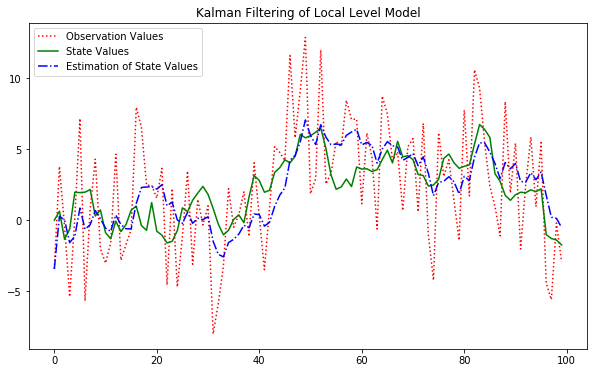

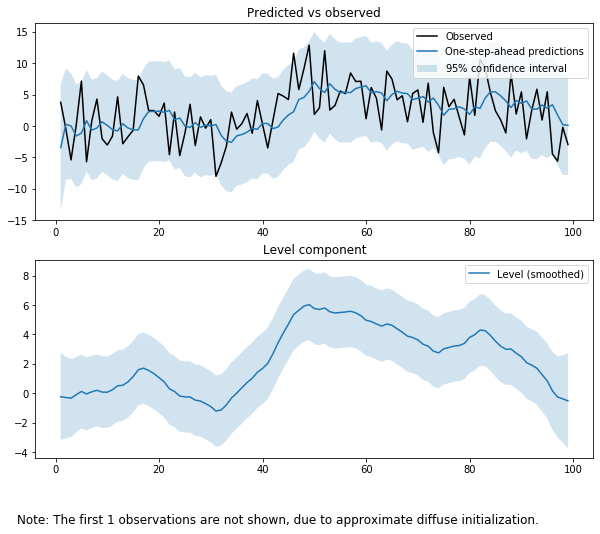

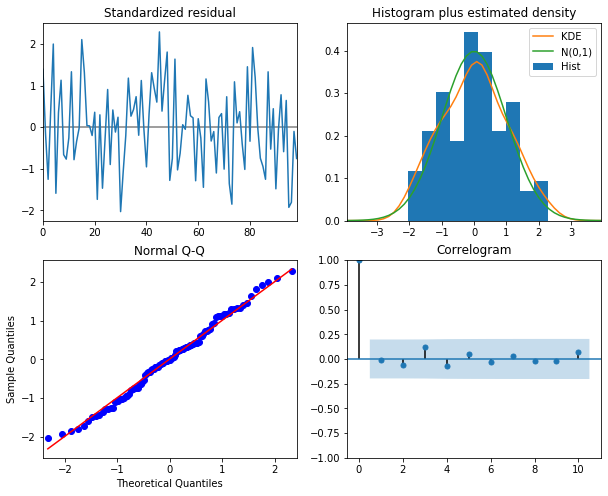

In [8]:
# 추정치 시각화
plt.figure(figsize=(10,6))
plt.plot(y_gener_target, 'r:', label="Observation Values")
plt.plot(x_gener_target, 'g-', label="State Values")
plt.plot(fit.filtered_state[0], 'b-.', label="Estimation of State Values")
plt.legend()
plt.title("Kalman Filtering of Local Level Model")
plt.show()

# 레벨추정 성분 시각화
fit.plot_components(figsize=(10,8))
plt.show()

# 잔차진단
fit.plot_diagnostics(figsize=(10,8))
plt.show()

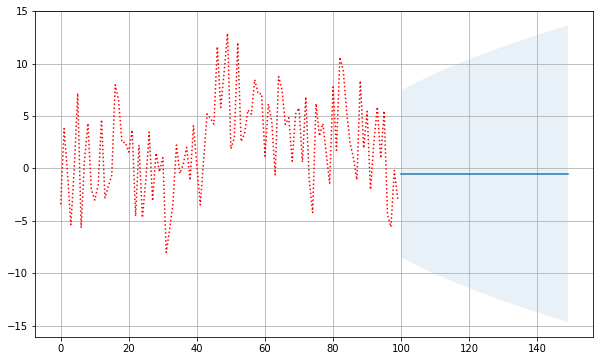

In [9]:
# 예측
plt.figure(figsize=(10,6))
forecast = fit.get_forecast(50)
plt.plot(y_gener_target, 'r:', label="Observation Values")
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(y_gener_target), len(y_gener_target) + len(forecast_ci))
plt.plot(forecast_index, forecast.predicted_mean, label="Observation Values")
plt.fill_between(forecast_index, forecast_ci[:, 0], forecast_ci[:, 1], alpha=0.1)
plt.grid()
plt.show()

#### 로컬선형레벨 모형

> 랜덤 워크 모형의 관측값이 다시 누적된 것으로 랜덤워크 과정을 따르는 단변수 상태변수 $\beta_t$를 가짐
\begin{align*}
&& \beta_t &= \beta_{t-1} + w_{\beta,t} &,\;\;\; & w_{\beta,t} \sim N(0, \sigma_\beta^2) \\
&& \mu_t &= \mu_{t-1} + \beta_{t-1} + w_{\mu,t} &,\;\;\; & w_{\mu,t} \sim N(0, \sigma_\mu^2) \\
&& Y_{t} &= \mu_{t} + v_t &,\;\;\; & v_t \sim {N}(0, \sigma_v^2) \\
\text{Matrix Form} &&
\begin{bmatrix}
\beta_t \\ \mu_t
\end{bmatrix}
&=
\begin{bmatrix}
1 & 0 \\ 1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\beta_{t-1} \\ \mu_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
w_{\beta,t} \\ w_{\mu,t}
\end{bmatrix}
\end{align*}

- **로컬선형레벨 모형 $\Longrightarrow$ ARIMA 모형**

> **로컬선형레벨 모형은 ARIMA(0,2,2)의 다른표현**
> - $\Delta^2 Y_t$는 $MA(2)$ 모형을 따르고 $Y_t$는 $ARIMA(0,2,2)$ 모형을 따름

\begin{align*}
\text{Setting of $\mu_t$} && \mu_t &= Y_t - v_t \\
\text{Equation of Local Level Model} && Y_t - v_t &= Y_{t-1} - v_{t-1} + \beta_{t-1} + w_{\mu,t} \\
&& \Delta Y_t &= Y_t - Y_{t-1} = \beta_{t-1} + w_{\mu,t} + v_t - v_{t-1} \\
\text{Equation of Local Level Model($\beta$)} && \beta_{t-1} &= \Delta Y_t - w_{\mu,t} - v_t + v_{t-1} \\
&& \Delta Y_{t+1} - w_{\mu,t+1} - v_{t+1} + v_{t} &= \Delta Y_t - w_{\mu,t} - v_t + v_{t-1}  + w_{\beta,t} \\
&& \Delta Y_{t+1} - \Delta Y_t &= w_{\mu,t+1} + v_{t+1} - v_{t} - w_{\mu,t} - v_t + v_{t-1}  + w_{\beta,t} \\
\text{Equation of ARIMA Model} && \Delta^2 Y_{t+1} &= w_{\mu,t+1} + v_{t+1} - v_{t} - w_{\mu,t} - v_t + v_{t-1}  + w_{\beta,t} \\
\end{align*}

- **예시문제1:**  
    1) 어떤 섬 근처에서 배가 엔진을 끄고 정지해 다가 어느 시점에 일정 속도로 움직이기 시작했다.  
    2) 배의 속도 $\beta_t$는 일정하게 유지하고자 하지만 기관의 특성상 조금씩 속도의 변화가 누적될 수 있고, 이 속도 변화 $w_{\beta,t}$는 가우시안 정규 분포를 따른다고 가정하자.  
    3) 또한 배의 속도 $\beta_t$에 의해 배의 위치 $\mu_t$는 변화하게 되는데 이 경우에도 파도의 힘에 의해 조금씩 앞뒤로 위치가 바뀔 수 있고 이 미세한 위치 변화 $w_{\mu,t}$도 가우시안 정규 분포를 따른다고 가정하자.  
    4) 매 시간마다 배의 선원은 섬으로부터의 거리 $Y_t$를 배에 있는 초음파 거리계(ultrasonic range finder)로 측정한다.  
    5) 이러한 경우에 정확한 거리 $\mu_t$를 알고자 하는 것이 바로 로컬 레벨 모형의 필터링(filtering) 문제가 된다.  
    (*로컬 선형 추세 모형은 오차가 큰 GPS 신호를 사용한 네비게이션에서 차량의 정확한 위치를 추정하는데도 사용된다.)  

- **예시문제2:**  
    1) 거시경제(macro economics) 모형에서 사용하는 대부분의 지표값은 시간이 지나며 선형적 혹은 지수함수적으로 증가하는 경우가 많다.  
    2) 이러한 시계열 값은 모두 로컬 선형 추세 모형으로 모형화가 가능하다.    

#### 실습: 로컬선형레벨 모형 데이터생성 및 이해

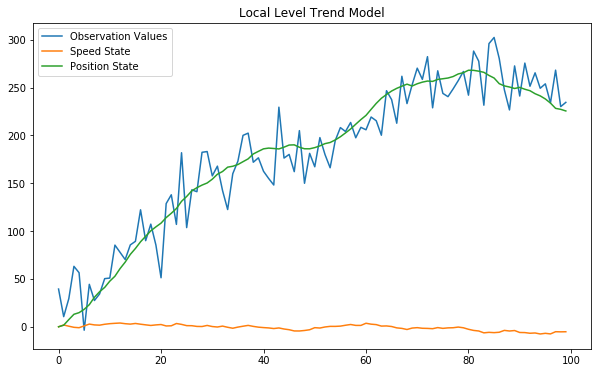

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:             local linear trend   Log Likelihood                -454.188
Date:                Fri, 13 Mar 2020   AIC                            914.377
Time:                        23:32:12   BIC                            922.132
Sample:                             0   HQIC                           917.513
                                - 100                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   455.8288     79.801      5.712      0.000     299.423     612.235
sigma2.level      2.012e-06     28.472   7.07e-08      1.000     -55.805      55.805
sigma2.trend         0.4817      0.497      0.969      0.332      -0.492       1.456
===================================================================================
Ljung-Box (Q):                       48.05   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.18   Prob(JB):                         0.70
Heteroskedasticity (H):               0.68   Skew:                            -0.15
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

# 데이터 생성
np.random.seed(0)
model_generator = KalmanFilter(k_endog=1, k_states=2, transition=[[1, 0], [1, 1]], 
                               state_intercept=[[0], [3]], selection=[[1, 0], [0, 1]], state_cov=[[1, 0], [0, 1]],
                               design=[[0, 1]], obs_cov=[[500]])
y_gener, x_gener = model_generator.simulate(100)

# 데이터 생성
plt.figure(figsize=(10,6))
plt.plot(y_gener, label="Observation Values")
plt.plot(x_gener.T[0], label="Speed State")
plt.plot(x_gener.T[1], label="Position State")
plt.legend()
plt.title("Local Level Trend Model")
plt.show()

# 로컬선형레벨모형 추정
fit = sm.tsa.UnobservedComponents(y_gener, level='local linear trend').fit()
fit.summary()

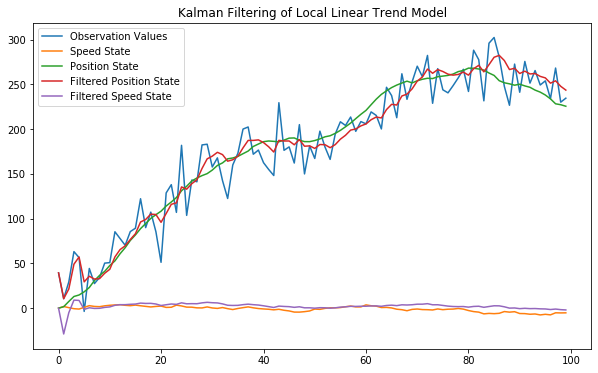

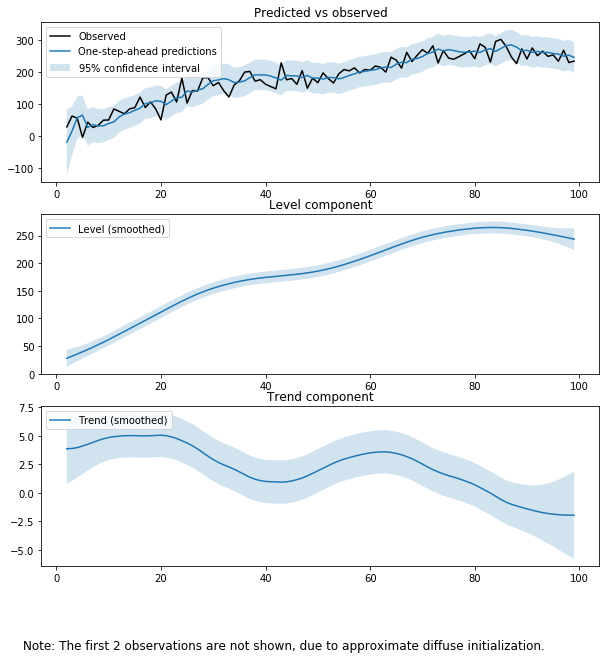

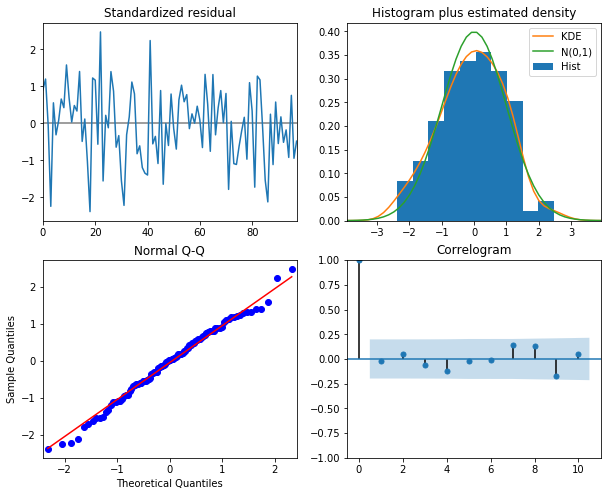

In [11]:
# 추정치 시각화
plt.figure(figsize=(10,6))
plt.plot(y_gener, label="Observation Values")
plt.plot(x_gener.T[0], label="Speed State")
plt.plot(x_gener.T[1], label="Position State")
plt.plot(fit.filtered_state[0], label="Filtered Position State")
plt.plot(fit.filtered_state[1], label="Filtered Speed State")
plt.legend()
plt.title("Kalman Filtering of Local Linear Trend Model")
plt.show()

# 레벨추정 성분 시각화
fit.plot_components(legend_loc=2, figsize=(10,10))
plt.show()

# 잔차진단
fit.plot_diagnostics(figsize=(10,8))
plt.show()

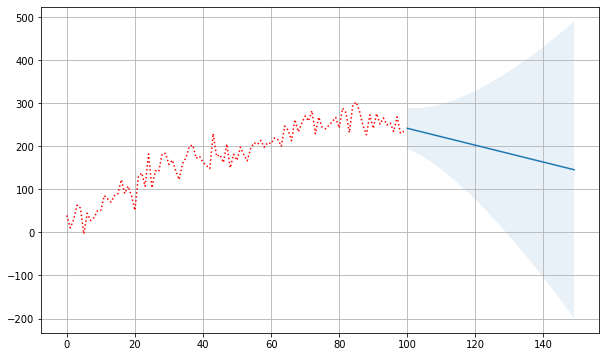

In [12]:
# 예측
plt.figure(figsize=(10,6))
forecast = fit.get_forecast(50)
plt.plot(y_gener, 'r:', label="Observation Values")
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(y_gener), len(y_gener) + len(forecast_ci))
plt.plot(forecast_index, forecast.predicted_mean, label="Observation Values")
plt.fill_between(forecast_index, forecast_ci[:, 0], forecast_ci[:, 1], alpha=0.1)
plt.grid()
plt.show()

### 상태공간모형 기반의 시계열 "구조화모형"

> **개별적 동적 특성(Dynamics, Transition Equation)을 정의할 수 있는 성분의 합 등으로 구성된 모형을 구조적 모형 또는 구조화 모형(Structural Model)**
> - 로컬 선형추세 모형에서 볼 수 있듯 상태공간모형의 장점은 실제로 관측된 하나의 시계열 자료로 부터 복수의 상태변수 시계열자료를 추정할 수 있다는 점
> - 각각의 상태변수가 동적특성(Dynamics), 즉 상태 전이식(State Transition Equantion)에 대한 가정 필요
> - 하나의 시계열 자료가 실제 여러개의 보이지 않는 성분들(Unobserved Components)이 합쳐진 것이라고 가정하고 각각의 성분을 추정하는 것이 가능(시계열 성분분리 가능)
> - 각 성분의 동적특성을 이미 알거나 가정해야 하며 각 동적 특성이 구별가능할 정도로 충분이 달라야 함
> - 보이지 않는 성분을 추정하는 모형이므로 Unobserved Component 모형이라고도 불림
> - 예시: 시계열 = 추세성분 + 계절성성분 + ARMA성분

> \begin{align*}
\text{Main Equation} && Y_{T} &= T_{t} + S_{t} + A_{t} \\
\text{Each Equations} && T_{t} &= \Phi_T T_{t-1} + w_{T,t} \\
&& S_{t} &= \Phi_S S_{t-1} + w_{S,t} \\
&& A_{t} &= \Phi_A A_{t-1} + w_{A,t} \\
\text{Matrix Form} &&
Y_{T} &=
\begin{bmatrix}
1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
T_{t} \\ S_{t} \\ A_{t} \\
\end{bmatrix}
+ v_t \\
\text{where} &&
\begin{bmatrix}
T_{t} \\ S_{t} \\ A_{t} \\
\end{bmatrix}
&=
\begin{bmatrix}
\Phi_T &   0     &        \\
0      & \Phi_S  &      0 \\
0      &      0  & \Phi_A \\
\end{bmatrix}
\begin{bmatrix}
T_{t-1} \\ S_{t-1} \\ A_{t-1} \\
\end{bmatrix}
+
\begin{bmatrix}
w_{T,t} \\ w_{S,t} \\ w_{A,t} \\
\end{bmatrix} \\
\end{align*}

- **구조화모형 성분:**  
    1) 추세(Trend) 성분  
    2) 계절성(Seasonal) 성분  
    3) 주기적(Cyclical) 성분  
    4) AR(Autoregressive) 성분  
    5) 회귀(Regression) 성분  
  
**1) 추세(Trend) 성분:** 로컬레벨 모형이나 로컬선형추세 모형도 추세성분 모형의 일종

- 레벨모형
\begin{align*}
\text{Fixed Intercept} && y_t &= \mu \\
\text{Deterministic Constant} && y_t &= \mu + \varepsilon_t \\
\text{Local Level} && y_t &= \mu_t + \varepsilon_t \\
&& \mu_t &= \mu_{t-1} + \eta_t \\
\end{align*}

- 결정론적 추세
\begin{align*}
\text{Fixed Slope} && y_t &= \mu_t \\
&& \mu_t &= \mu_{t-1} + \beta \\
\text{Deterministic Trend} && y_t &= \mu_t + \varepsilon_t \\
&& \mu_t &= \mu_{t-1} + \beta \\
\text{Local Linear Deterministic Trend} && y_t &= \mu_t + \varepsilon_t \\
&& \mu_t &= \mu_{t-1} + \beta + \eta_t \\
\end{align*}
  
- 확률론적 추세
\begin{align*}
\text{Random Walk} && y_t &= \mu_t \\
&& \mu_t &= \mu_{t-1} + \eta_t \\
\text{Random Walk with Drift} && y_t &= \mu_t \\
&& \mu_t &= \mu_{t-1} + \beta + \eta_t \\
\text{Local Linear Trend} && y_t &= \mu_t + \varepsilon_t \\
&& \mu_t &= \mu_{t-1} + \beta_{t-1} + \eta_t \\
&& \beta_t &= \beta_{t-1} + \zeta_t \\
\end{align*}

**2) 계절성(Seasonality) 성분:** 주기가 명확한 성분
> - 분기/월/요일/시간 등에 결정되는 반복적 요소는 계절성 성분, 주기적(Cyclical) 성분과는 구분됨
> - 주기내의 값이 원래 일정(Level or Flat)해야 하는 것이 주기성에 의해 흔들린다고 보는 것
> - 계절성 성분은 한 주기 내 각 성분의 합이 0이 되는 모형을 사용하며, 여기에 추가적으로 가우시안 잡음이 더해질 수 있음
> - 예시: 4개의 계절성을 가지는 경우

> \begin{align*}
\text{4 Seasonality} && S_t + S_{t-1} + S_{t-2} + S_{t-3} &= w_{S,t} \\
\text{Matrix Form} &&
\begin{bmatrix}
S_{t} \\ S_{t-1} \\ S_{t-2} \\
\end{bmatrix}
&=
\begin{bmatrix}
-1 & -1 & -1 \\  1 &  0 &  0 \\  0 &  1 &  0 \\
\end{bmatrix}
\begin{bmatrix}
S_{t-1} \\ S_{t-2} \\ S_{t-3} \\
\end{bmatrix}
+
\begin{bmatrix}
w_{S, t} \\ 0 \\ 0 \\
\end{bmatrix} \\
\end{align*}

**3) 주기적(Cyclical) 성분:** 주기가 명확하지 않거나 크기가 일정하지 않은 성분
> - 모수 $\lambda_c$를 가지는 하모닉 상태 변수 쌍(pair)으로 모형화가 가능
> - 만약 $\rho_c$가 1보다 작으면 점차 감소하는(damped) 주기적 성분

> \begin{align*}
\text{Pairwise Cycle}
&& c_{t}   & = \rho_c (  \tilde c_{t} \cos \lambda_c t + \tilde c_{t}^* \sin \lambda_c t) + \tilde w_{t} \\
&& c_{t}^* & = \rho_c (- \tilde c_{t} \sin \lambda_c t + \tilde c_{t}^* \cos \lambda_c t) + \tilde w_{t}^* \\
\text{Matrix Form} &&
\begin{bmatrix}
c_{t} \\ c_{t}^* \\
\end{bmatrix}
&= \rho_c
\begin{bmatrix}
 \cos \lambda_c t & \sin \lambda_c t \\ -\sin \lambda_c t & \cos \lambda_c t \\
\end{bmatrix}
\begin{bmatrix}
c_{t-1} \\ c_{t-1}^* \\
\end{bmatrix}
+
\begin{bmatrix}
w_{C, t} \\ w_{C, t}^* \\
\end{bmatrix} \\
&& & \text{(*행렬식의 계수는 시간에 따라 계속 변화함)}
\end{align*}

**4) AR 성분:** 일반적인 AR(p) 성분 모형도 상태 변수 형태로 변환 가능

**5) 회귀 성분:** 내부 이노베이션 과정을 입력으로 가지는 것이 아니라 외부(Exogenous) 입력신호를 선형회귀식 형태로 가지는 성분

#### 실습: 구조화모형을 사용한 성분 분리

\begin{align*}
y_t & = \mu_t + \eta_t \\
\mu_{t+1} & = \mu_t + \epsilon_{t+1} \\
\eta_{t+1} & = \eta_t \cos \lambda_\eta + \eta_t^* \sin \lambda_\eta + \tilde \omega_t \qquad & \tilde \omega_t \sim N(0, \sigma_{\tilde \omega}^2) \\
\eta_{t+1}^* & = -\eta_t \sin \lambda_\eta + \eta_t^* \cos \lambda_\eta + \tilde \omega_t^* & \tilde \omega_t^* \sim N(0, \sigma_{\tilde \omega}^2)
\end{align*}

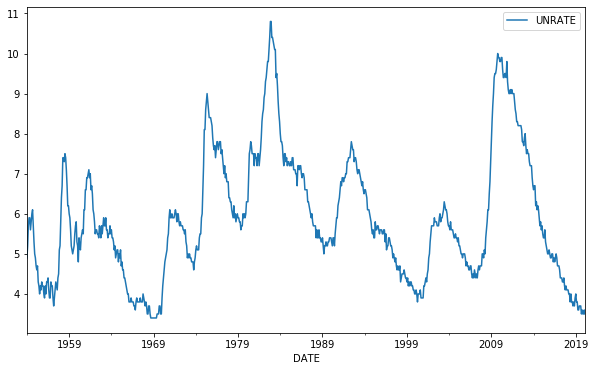

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
import pandas_datareader.data as web

# 데이터 로딩
unemployment_US = web.DataReader('UNRATE', 'fred', start='1954-01-01')
unemployment_US.plot(figsize=(10,6))
plt.show()

Optimization terminated successfully.
         Current function value: -0.278485
         Iterations: 8
         Function evaluations: 424


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                        UNRATE   No. Observations:                  794
Model:                           random walk   Log Likelihood                 221.117
                   + damped stochastic cycle   AIC                           -434.235
Date:                       Fri, 13 Mar 2020   BIC                           -415.541
Time:                               23:32:22   HQIC                          -427.050
Sample:                           01-01-1954                                         
                                - 02-01-2020                                         
Covariance Type:                         opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level        0.0146      0.005      2.879      0.004       0.005       0.025
sigma2.cycle        0.0167      0.005      3.403      0.001       0.007       0.026
frequency.cycle     0.0698      0.005     13.611      0.000       0.060       0.080
damping.cycle       0.9896      0.004    238.884      0.000       0.982       0.998
===================================================================================
Ljung-Box (Q):                      170.99   Jarque-Bera (JB):                86.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

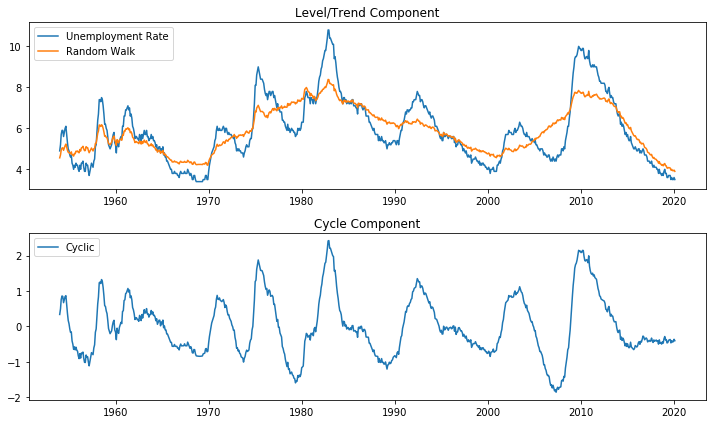

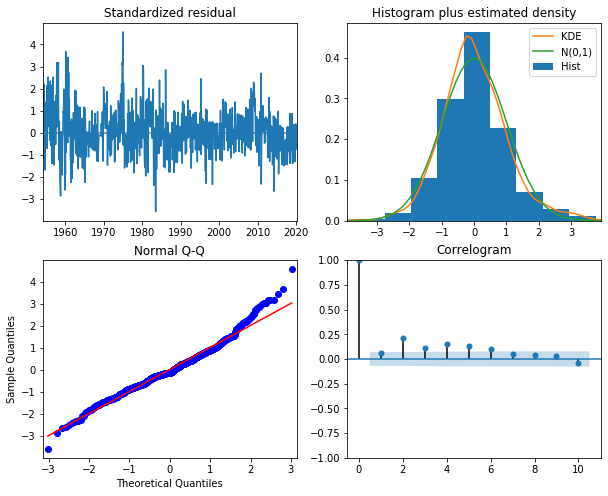

In [14]:
# 구조화모형 추정
model = sm.tsa.UnobservedComponents(unemployment_US, level='rwalk', cycle=True, 
                                  stochastic_cycle=True, damped_cycle=True)
result = model.fit(method='powell')
display(result.summary())

# 추정 시각화
fig, axes = plt.subplots(2, figsize=(10,6))
axes[0].plot(unemployment_US.index, unemployment_US.UNRATE, label='Unemployment Rate')
axes[0].plot(unemployment_US.index, result.level.smoothed, label='Random Walk')
axes[0].legend(loc='upper left')
axes[0].set(title='Level/Trend Component')
axes[1].set(title='Cycle Component')
axes[1].plot(unemployment_US.index, result.cycle.smoothed, label='Cyclic')
axes[1].legend(loc='upper left')
fig.tight_layout()
plt.show()

# 잔차진단
result.plot_diagnostics(figsize=(10,8))
plt.show()

- **주기적 성분 대신 AR(4) 모형 대체**

\begin{align*}
y_t & = \mu_t + \eta_t \\
\mu_{t+1} & = \mu_t + \epsilon_{t+1} \\
\phi(L) \eta_t & = \nu_t
\end{align*}

Optimization terminated successfully.
         Current function value: -0.324535
         Iterations: 8
         Function evaluations: 614


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 UNRATE   No. Observations:                  794
Model:                    random walk   Log Likelihood                 257.681
                              + AR(4)   AIC                           -503.362
Date:                Fri, 13 Mar 2020   BIC                           -475.307
Time:                        23:32:27   HQIC                          -492.580
Sample:                    01-01-1954                                         
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.0172      0.003      6.277      0.000       0.012       0.023
sigma2.ar        0.0109      0.003      3.579      0.000       0.005       0.017
ar.L1            1.0368      0.064     16.127      0.000       0.911       1.163
ar.L2            0.4734      0.103      4.580      0.000       0.271       0.676
ar.L3           -0.3340      0.122     -2.729      0.006      -0.574      -0.094
ar.L4           -0.1866      0.075     -2.490      0.013      -0.333      -0.040
===================================================================================
Ljung-Box (Q):                       75.39   Jarque-Bera (JB):                45.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

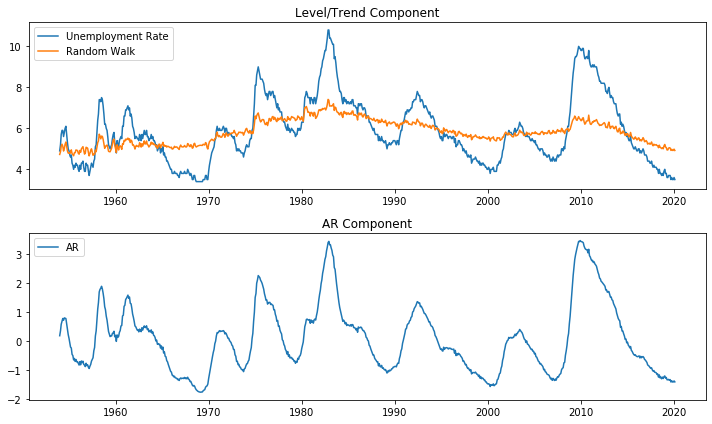

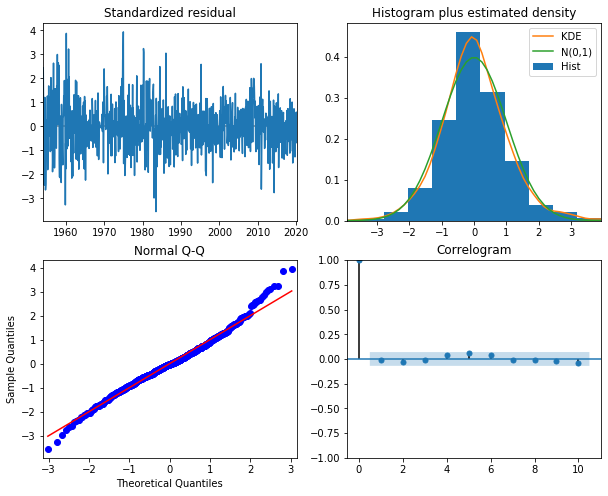

In [15]:
# 구조화모형 추정
model = sm.tsa.UnobservedComponents(unemployment_US, level='rwalk', autoregressive=4)
result = model.fit(method='powell')
display(result.summary())

# 추정 시각화
fig, axes = plt.subplots(2, figsize=(10,6))
axes[0].plot(unemployment_US.index, unemployment_US.UNRATE, label='Unemployment Rate')
axes[0].plot(unemployment_US.index, result.level.smoothed, label='Random Walk')
axes[0].legend(loc='upper left')
axes[0].set(title='Level/Trend Component')
axes[1].set(title='AR Component')
axes[1].plot(unemployment_US.index, result.autoregressive.smoothed, label='AR')
axes[1].legend(loc='upper left')
fig.tight_layout()
plt.show()

# 잔차진단
result.plot_diagnostics(figsize=(10,8))
plt.show()

### 확장 알고리즘 및 응용 예시

**1) 확률적 변동성 모형 (Stochastic Volatility Model)**
> - 정적 변동성 모형: ARCH(Autoregressive conditional heteroskedasticity), GARCH(Generalized Autoregressive conditional heteroskedasticity)  
> - 정적 변동성 모형과 달리 변동성 자체를 하나의 독립적인 상태 변수로 가정 
> - 널리 사용되는 Heston 모형은 다음과 같이 분산(Variance) 상태 변수 $\nu_t$를 가지는 연속 시간 모형 

\begin{align*}
dS_t   &= \mu S_t\,dt + \sqrt{\nu_t} S_t\,dW^S_t  \\
d\nu_t &= \kappa(\theta - \nu_t)\,dt + \xi \sqrt{\nu_t}\,dW^{\nu}_t
\end{align*}


**2) 히든 마코프 모형 (HMM: Hidden Markov Model)**
> - 상태 변수  $x$ 값이 연속 확률변수가 아니라 1차원 이산 확률변수(Discrete Random Variable)인 경우 히든 마코프 모형이 됨 
> - 히든 마코프 모형의 상태 전이식은 다음과 같은 조건부 확률로 정의됨 
> - 주로 음성 처리에서 많이 사용되지만 경제학 분야에서도 구조적 변화에 의한 시계열 특성이 변화하는 경우에 사용됨 

- **독립 혼합 모형(Independent Mixuture Model)**

> **연속 확률변수임에도 단일 확률분포를 가지지 않고 복수의 확률분포를 가지는 경우, 독립적 이산 확률분포로 복수의 확률분포를 추정하는 모형**
> \begin{align*}
p(y) &= \sum_{i=1}^m {P}(C=i)\cdot {P}(Y=y|C=i) \\
&= \sum_{i=1}^m \delta_i p_i(y)
\end{align*}
> - $p(y)$: 전체 Independent Mixuture 분포
> - $pi(y)$: Independent Mixuture 각 성분(Component)의 개별적인 연속 확률분포
> - $\delta_i$: Mixing Parameter로 특정시간의 모든 성분 중 특정한 $pi(y)$가 선택될 확률(이산 확률 분포)
> - $\sum \delta_i$: Mixing Parameter에 대한 확률 제한 조건

> - **예시: 베르누이-정규 혼합모형(Binomial Normal-Mixture Model)**
    - 베르누이 확률변수의 값에 따라 두개의 서로다른 연속정규분포 중 하나를 선택하는 확률분포
    <center><img src='Image/HMM_Normal-Mixture.png' width='500'></center> 
  

- **마코프 체인(Markov Chain)**

> - **마코프 체인(Markov Chain):** 다음과 같은 특성을 가진 이산시간 확률 프로세스
> \begin{align*}
P(C_{t+1} \mid C_t, \cdots, C_1) = P(C_{t+1} \mid C_t)
\end{align*}
> - **전이확률(Transition Probability):** $t$시간 동안 특정 상태 $i$에서 다른 상태 $j$로 전이할 확률
> \begin{align*}
\gamma_{ij}(t) = P(C_{s+t}=j|C_{s}=i)
\end{align*}
> - **전이행렬(Transition Matrix):** 모든 상태조합에 대한 전이확률
> \begin{align*}
\Gamma(t) = \{ \gamma_{ij}(t) \}, \;\;\; \Gamma = \Gamma(1)
\end{align*}
> - **체프먼-콜모고로프 방정식(Chapman-Kolmogorov Equation):** 시간 $t+u$의 전이확률행렬은 시간$t$의 전이확률행렬과 시간 $u$의 전이확률행렬의 곱
> \begin{align*}
\Gamma(t+u) = \Gamma(t)\Gamma(u)
\end{align*}
> - **디코드(Decode):** 관측된 HMM 모형의 연혹 확률변수 값으로 내부의 이산 확률변수 값을 추정하는 과정


- **히든 마코프 모형(Hidden Markov Model)**

> **독립 혼합 모형에서 연속 확률분포를 선택하는 이산확률과정 $C_t$가 마코프 체인이고 연속확률분포 $Y_t$가 그 시점의 이산 확률과정의 값에만 의존하는 모형**
> - 연속 확률 분포의 값 $X_t$만 측정 가능하고 이산 확률 과정의 값 $C_t$는 측정 불가
> \begin{align*}
P(C_t \mid |C_{t-1}, \cdots, C_1) = P(C_t \mid C_{t-1}) \\
P(Y_t \mid Y_t, \cdots, Y_1, C_t, \cdots, C_1) = P(Y_t \mid C_t)
\end{align*}
    <center><img src='Image/HMM_General.png' width='500'></center> 

- **HMM 모듈 정리**

~~~
from hmmlearn import hmm
~~~

| 클래스 이름 | 용도 |
|----------------|-----------------------------------------------------------|
| GaussianHMM | Hidden Markov Model with Gaussian emissions |
| GMMHMM | Hidden Markov Model with Gaussian mixture emissions |
| MultinomialHMM | Hidden Markov Model with multinomial (discrete) emissions |

- **GaussianHMM:** 카테고리-다변수 정규분포 혼합 모형 시뮬레이션

| 출력모듈 | 설명 |
|----------------|-----------------------------------------------------------|
| startprob_ | 초기 확률 벡터 |
| transmat_ | 전이 확률 행렬 |
| means_ | 정규 분포의 기댓값 벡터 |
| covars_ | 정규 분포의 공분산 행렬 |


**3) 칼만 필터**
> - 선형 동적 모형에 대한 필터링 문제와 스무딩 문제를 푸는 방법 중 가장 널리 쓰임 
> - 칼만 필터는 확률 변수의 분포를 갱신하는 베이지안 필터(Bayesian Filter)의 한 종류 
> - 가우시안 분포를 가지는 선형 시스템이라는 제약 조건을 훌륭하게 사용하여 상태 변수의 평균과 분산을 간단히 갱신하는 효율적 알고리즘 
> \begin{align*}
\text{Main Equation} && \alpha_t &= T_t \alpha_{t-1} + c_t + R_t \eta_t \\
&& y_t &= Z_t \alpha_t + d_t + \varepsilon_t \\
\text{where} && & \text{$\alpha_t$: State Vector} \\
&& & \text{$T_t$: Transition Matrix} \\
&& & \text{$c_t$: State Intercept Vector} \\
&& & \text{$R_t$: Selection Matrix} \\
&& & \text{$\eta_t \sim N(0, Q_t)$: Innovation Process Vector} \\
&& & \text{$Q_t$: State Covariance Matrix} \\
&& & \text{$y_t$: Observation Vector} \\
&& & \text{$Z_t$: Design Matrix} \\
&& & \text{$d_t$: Observation Intercept Vector} \\
&& & \text{$\epsilon_t \sim N(0, H_t)$: Observation Error Vector} \\
&& & \text{$H_t$: Observation Covariance Matrix} \\
\end{align*}

- [**Falman Filter 모듈 정리**](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.kalman_filter.KalmanFilter.html)

~~~
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
model = KalmanFilter(yt, k_states=1, transition=[[1]], selection=[[1]],
                     state_cov=[[10]], design=[[1]], obs_cov=[[100]])
~~~

| 입력옵션 | 설명 |
|--------------------|--------------------------------------------------------------------------------------------------------|
| k_endog | 정수 혹은 배열. 배열인 경우에는 칼만필터를 적용할 실제 시계열 자료. 정수인 경우에는 출력 변수의 수 |
| k_states | 정수. 상태 변수의 수 |
| k_posdef | (옵션) 정수. 출력 잡음의 공분산 중 양 한정(Positive Definite)을 보장하는 차원의 수. 디폴트는 k_states |
| transition | (옵션) 상태 전이 행렬(Transition Matrix). 디폴트는 0 |
| state_intercept | (옵션) 상태 전이식의 절편(Intercept for the Transition Equation). 디폴트는 0 |
| selection | (옵션) 이노베이션 과정에 대한 선택 행렬(Selection Matrix). 디폴트는 0 |
| state_cov | (옵션) 이노베이션 과정의 공분산 행렬. 디폴트는 0 |
| design | (옵션) 설계 행렬(Design Matrix). 디폴트는 0 |
| obs_intercept | (옵션) 관측식의 절편(Intercept for the Observation Equation). 디폴트는 0 |
| obs_cov | (옵션) 관측 행렬의 공분산 행렬. 디폴트는 0 |
| initial_state | (옵션) 배열. 초기 상태 변수 값 |
| initialization | (옵션) 다음 문자열 중 하나 {approximate_diffuse, stationary, known} (옵션) 상태 변수 초기화 방법 |
| initial_variance | (옵션) 실수. 초기화 방법이 Approximate_diffuse 일 경우의 초기 분산 값. 디폴트는 1e6 |
| initial_state_cov | (옵션) 배열. 초기화 방법이 Known 일 경우 사용하는 분산 행렬 |
| nobs | (옵션) 정수. k_endog가 정수인 경우에 시계열 자료의 길이를 표시 |
| loglikelihood_burn | (옵션) 정수. Log-likelihood를 기록하지 않는 Burn-in 구간의 길이. 디폴트는 0 |
| tolerance | (옵션) 실수. 상태변수의 수렴 기준. 디폴트는 1e-19 |

| 출력모듈 | 설명 |
|--------------------------------|-----------------------------------------|
| simulate | 모수가 모두 충족된 경우 시뮬레이션 수행 |
| initialize_known | 초기 상태 생성 (상태값을 아는 경우) |
| initialize_stationary | 초기 상태 생성 (정상 상태) |
| initialize_approximate_diffuse | 초기 상태 생성 |
| filter | 필터링. FilterResults 객체 출력 |


**4) 마코프 체인 몬테카를로 (MCMC: Markov Chain Monte Carlo)**
> - 상태 공간 모형의 확률 분포가 가우시안 정규 분포가 아니거나 정확한 분포의 수식을 알 수 없을 때 주로 활용 
> - MCMC 방법은 특정한 마코프 체인 확률 과정을 사용하여 생성한 시뮬레이션을 통해 분포의 형상을 추정 

**5) 응용 사례**
> - 자동 제어(automatic), 항법(navigation) 시스템. 신호처리(signal processing) 분야에 많이 사용 
> - 최근에는 경제학이나 일반 시계열 모형에서도 상태 공간 모형이 일반화 
> - [도립진자](https://www.youtube.com/watch?v=B6vr1x6KDaY), [카메라 안정기](https://www.youtube.com/watch?v=X2vvdJGxPkI), [드론 항법 장치](https://www.youtube.com/watch?v=7BoDS9Gzsko)

- **기존 ARMA 모형에서 다루기 힘든 문제들을 해결하는데 도움**  
1) 시계열의 구조적 모형(structural model)  
2) 일부 누락된 데이터(missing data)가 있는 경우  
3) 시간에 따라 모형 계수가 변화(time-varing or switching)하는 경우  
4) 변수의 분포가 정규 분포가 아닌 경우  

#### 실습: HMM 데이터생성 및 이해

In [16]:
# import numpy as np
# from hmmlearn import hmm
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 데이터 생성
# np.random.seed(3)
# model = hmm.GaussianHMM(n_components=2, covariance_type="diag")
# model.startprob_ = np.array([0.9, 0.1])
# model.transmat_ = np.array([[0.95, 0.05], [0.15, 0.85]])
# model.means_ = np.array([[1.0], [-3.0]])
# model.covars_ = np.array([[15.0], [40.0]])
# X, Z = model.sample(500)

# # 데이터 시각화
# plt.figure(figsize=(10,6))
# sns.distplot(X)
# plt.show()

# plt.figure(figsize=(10,6))
# plt.subplot(311)
# plt.plot(X)
# plt.title("random variable")
# plt.subplot(312)
# plt.plot(Z)
# plt.title("discrete state")
# plt.subplot(313)
# plt.plot((1 + 0.01*X).cumprod())
# plt.title("X cumulated")
# plt.tight_layout()
# plt.show()

# # HMM 모델링
# fit = hmm.GaussianHMM(n_components=2, n_iter=len(X)).fit(X)
# Z_hat = fit.decode(X)[1]
# X_cum = (1 + 0.01*X).cumprod()
# X_cum_hat = X_cum.copy()
# X_cum_hat[Z_hat == 0] = np.nan

# # Generator 시각화
# plt.figure(figsize=(10,6))
# plt.subplot(211)
# plt.plot(X_cum, lw=5)
# plt.plot(X_cum_hat, 'r-', lw=5)
# plt.title("X cumulated")
# plt.subplot(212)
# plt.plot(Z, 'bo-')
# plt.plot(Z_hat, 'ro-')
# plt.title("discrete state")
# plt.tight_layout()
# plt.show()

#### 실습: Kalman Filter 데이터생성 및 이해

\begin{align*}
\mu_t &= \mu_{t-1} + w_t,\;\;\;  &w_t \sim N(\mu=0, \sigma^2=10) \\
Y_{t} &= \mu_{t}   + v_t,\;\;\;  &v_t \sim N(\mu=0, \sigma^2=100) \\
\end{align*}

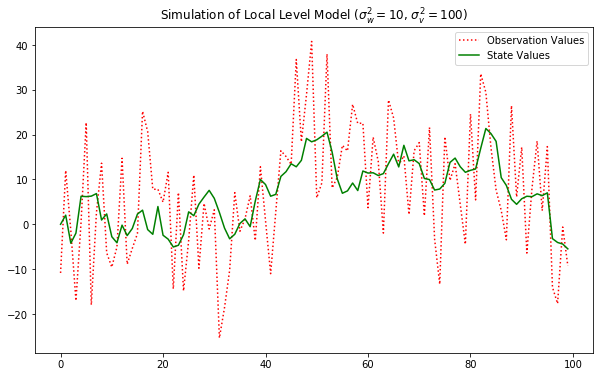

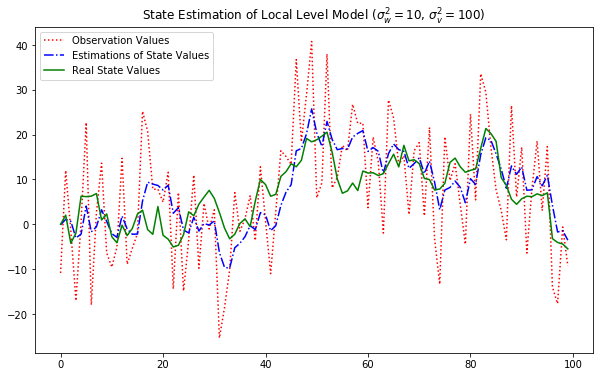

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

# 데이터 생성
np.random.seed(123)
model_generator = KalmanFilter(k_endog=1, k_states=1,
                               transition=[[1]], selection=[[1]], state_cov=[[10]],
                               design=[[1]], obs_cov=[[100]])
y_gener, x_gener = model_generator.simulate(100)

# 데이터 생성
plt.figure(figsize=(10,6))
plt.plot(y_gener, 'r:', label="Observation Values")
plt.plot(x_gener, 'g-', label="State Values")
plt.legend()
plt.title("Simulation of Local Level Model ($\sigma_w^2 = 10$, $\sigma_v^2 = 100$)")
plt.show()

# Kalman Filter 모델링
fit = KalmanFilter(y_gener, k_states=1,
                   transition=[[1]], selection=[[1]], state_cov=[[10]],
                   design=[[1]], obs_cov=[[100]])
fit.initialize_known([0], [[1]])
result = fit.filter()

# 추정 시각화
plt.figure(figsize=(10,6))
plt.plot(fit.obs[0], 'r:', label="Observation Values")
plt.plot(result.filtered_state[0], "b-.", label="Estimations of State Values")
plt.plot(x_gener, "g-", label="Real State Values")
plt.legend()
plt.title("State Estimation of Local Level Model ($\sigma_w^2 = 10$, $\sigma_v^2 = 100$)")
plt.show()

# 다변량 시계열 알고리즘

- **필요성:**
    - 단변량 시계열(Simple/Multiple포함)은 종속변수($Y_t$)가 독립변수들에만! 영향을 받는다는 큰 가정 존재
    - 현실적으론 종속변수와 독립변수는 상호 영향을 주고받음
        - 예시: 개인 소득과 지출 중 어떤게 Y로 적합한가?라는 질문은 왜 하지 않는가?

> **2차원(소득과 지출 모두를 종속변수) 과거1시점까지만을 고려하는 백터자기회귀 알고리즘**

>\begin{align*}
\text{Equation of VAR(1)} && Y_{[t]} &= A Y_{[t-1]} + \epsilon_{[t]} \\
\text{where} && Y_{[t]} &= \begin{bmatrix} Y_{1t} \\ Y_{2t} \end{bmatrix},
A = \begin{bmatrix} \phi_{11} \phi_{12} \\ \phi_{21} \phi_{22} \end{bmatrix},
Y_{[t-1]} = \begin{bmatrix} Y_{1t-1} \\ Y_{2t-1} \end{bmatrix}, \\
&& \epsilon_{[t]} &= \begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix} \sim N(0, \textstyle \sum_{\epsilon_{[t]}}) \\
\text{Each Equation of VAR(1)} && Y_{1t} &= \phi_{11} Y_{1t-1} + \phi_{12} Y_{2t-1} + e_{1t} \\
&& Y_{2t} &= \phi_{21} Y_{1t-1} + \phi_{22} Y_{2t-1} + e_{2t} \\
\end{align*}

## 벡터자기회귀 모형(Vector Autoregressive Model)

**1) VAR 알고리즘:**
> **단변량 시계열과 같이 평균 벡터와 공분산 벡터가 시차 $l$에만 의존하고 각각의 절대위치에 독립적이면 정상성(Stationary) 시계열**

\begin{align*}
\text{Generalized Equation of VAR(1)} && Y_{[t]} &= A_1 Y_{[t-1]} + e_t \\
\text{where} && Y_{[t]} &= \begin{bmatrix} Y_{1t} \\ Y_{2t} \\ \vdots \\ Y_{kt} \end{bmatrix},
A_1 = \begin{bmatrix} \phi_{11}^1 \phi_{12}^1 \cdots \phi_{1k}^1 \\ \phi_{21}^1 \phi_{22}^1 \cdots \phi_{2k}^1 \\ \vdots \\ \phi_{k1}^1 \phi_{k2}^1 \cdots \phi_{kk}^1 \end{bmatrix},
Y_{[t-1]} = \begin{bmatrix} Y_{1t-1} \\ Y_{2t-1} \\ \vdots \\ Y_{kt-1} \end{bmatrix}, \\
&& \epsilon_{[t]} &= \begin{bmatrix} e_{1t} \\ e_{2t} \\ \vdots \\ e_{kt} \end{bmatrix} \sim N(0, \textstyle \sum_{\epsilon_{[t]}}) \\
\text{Each Equations} && Y_{1t} &= \phi_{11}^1 Y_{1t-1} + \phi_{12}^1 Y_{2t-1} + \cdots + \phi_{1k}^1 Y_{kt-1} + e_{1t} \\
&& Y_{2t} &= \phi_{21}^1 Y_{1t-1} + \phi_{22}^1 Y_{2t-1} + \cdots + \phi_{2k}^1 Y_{kt-1} + e_{2t} \\
&& & \vdots \\
&& Y_{kt} &= \phi_{k1}^1 Y_{1t-1} + \phi_{k2}^1 Y_{2t-1} + \cdots + \phi_{kk}^1 Y_{kt-1} + e_{kt} \\
\end{align*}


\begin{align*}
\text{Generalized Equation of VAR(2)} && Y_{[t]} &= A_1 Y_{[t-1]} + A_2 Y_{[t-2]} + e_t \\
\text{where} && Y_{[t]} &= \begin{bmatrix} Y_{1t} \\ Y_{2t} \\ \vdots \\ Y_{kt} \end{bmatrix},
A_1 = \begin{bmatrix} \phi_{11}^1 \phi_{12}^1 \cdots \phi_{1k}^1 \\ \phi_{21}^1 \phi_{22}^1 \cdots \phi_{2k}^1 \\ \vdots \\ \phi_{k1}^1 \phi_{k2}^1 \cdots \phi_{kk}^1 \end{bmatrix},
Y_{[t-1]} = \begin{bmatrix} Y_{1t-1} \\ Y_{2t-1} \\ \vdots \\ Y_{kt-1} \end{bmatrix}, \\
&& A_2 &= \begin{bmatrix} \phi_{11}^2 \phi_{12}^2 \cdots \phi_{1k}^2 \\ \phi_{21}^2 \phi_{22}^2 \cdots \phi_{2k}^2 \\ \vdots \\ \phi_{k1}^2 \phi_{k2}^2 \cdots \phi_{kk}^2 \end{bmatrix},
Y_{[t-2]} = \begin{bmatrix} Y_{1t-2} \\ Y_{2t-2} \\ \vdots \\ Y_{kt-2} \end{bmatrix}, \\
&& \epsilon_{[t]} &= \begin{bmatrix} e_{1t} \\ e_{2t} \\ \vdots \\ e_{kt} \end{bmatrix} \sim N(0, \textstyle \sum_{\epsilon_{[t]}}) \\
\text{Each Equations} && Y_{1t} &= \phi_{11}^1 Y_{1t-1} + \phi_{12}^1 Y_{2t-1} + \cdots + \phi_{1k}^2 Y_{kt-1} + \phi_{11}^2 Y_{1t-2} + \phi_{12}^2 Y_{2t-2} + \cdots + \phi_{1k}^2 Y_{kt-2} + e_{1t} \\
&& Y_{2t} &= \phi_{21}^1 Y_{1t-1} + \phi_{22}^1 Y_{2t-1} + \cdots + \phi_{2k}^1 Y_{kt-1} + \phi_{21}^2 Y_{1t-2} + \phi_{22}^2 Y_{2t-2} + \cdots + \phi_{2k}^2 Y_{kt-2} + e_{2t} \\
&& & \vdots \\
&& Y_{kt} &= \phi_{k1}^1 Y_{1t-1} + \phi_{k2}^1 Y_{2t-1} + \cdots + \phi_{kk}^1 Y_{kt-1} + \phi_{k1}^2 Y_{1t-2} + \phi_{k2}^2 Y_{2t-2} + \cdots + \phi_{kk}^2 Y_{kt-2} + e_{kt} \\
\end{align*}


\begin{align*}
\text{Generalized Equation of VAR(p)} && Y_{[t]} &= A_1 Y_{[t-1]} + A_2 Y_{[t-2]} + \cdots + A_p Y_{[t-p]} + \epsilon_{[t]} \\
\text{Mean} && \mu_{[t]} &= \text{E}(Y_{[t]})
= \begin{bmatrix} \text{E}(Y_{1t}) \\ \text{E}(Y_{2t}) \\ \vdots \\ \text{E}(Y_{kt}) \end{bmatrix}
= \begin{bmatrix} \mu_{1} \\ \mu_{2}\\ \vdots \\ \mu_{k} \end{bmatrix} \\
\text{Covariance} && \Gamma(l) &= \text{E}[(Y_{[t]} − \mu_{[t]})(Y_{[t]} − \mu_{[t]})^T ] \\
&& &= \begin{bmatrix}
\text{E}[(Y_{1t} − \mu_1)^2] & \text{E}[(Y_{1t} − \mu_1)(Y_{2t} − \mu_2)] & \cdots & \text{E}[(Y_{1t} − \mu_1)(Y_{kt} − \mu_k)] \\
\text{E}[(Y_{2t} − \mu_2)(Y_{1t} − \mu_1)] & \text{E}[(Y_{2t} − \mu_2)^2] & \cdots & \text{E}[(Y_{2t} − \mu_2)(Y_{kt} − \mu_k)] \\
\vdots & \vdots & \ddots & \vdots \\
\text{E}[(Y_{kt} − \mu_k)(Y_{1t} − \mu_1)]& \text{E}[(Y_{kt} − \mu_k)(Y_{2t} − \mu_2)] & \cdots  & \text{E}[(Y_{kt} − \mu_k)^2]  \\
\end{bmatrix} \\
\text{Covariance Diagonal} && D &= \text{diag}(\sqrt{\Gamma_{11}}, \cdots, \sqrt{\Gamma_{kk}}) \\
\text{Cross-correlation Matrix} && \rho(l) &= D^{−1}\Gamma(l)D^{−1} \\
\end{align*}


**2) 임펄스 응답 함수(Impulse Response Function):**

> **VAR 모형은 여러개의 시계열 상호상관관계를 기반으로 각각의 변수가 다른 변수에 어떤 영향을 주는지 임펄스 반응 함수로 알 수 있음**
> - **임펄스(Impulse):** 어떤 시계열이 $t=0$ 일 때 1이고, $t<0$ 또는 $t>1$ 일 때 0인 것
> - **임펄스 반응 함수(Impulse Response Function):** 임펄스 형태의 시계열이 다른 시계열에 미치는 영향을 시간에 따라 표시


### VAR 모듈 정리

| 클래스 이름 | 용도 |
|-------------|-----------------------------------------------|
| VARProcess | 미리 정해진 계수를 가진 $VAR$ 모형 |
| VAR | 주어진 자료의 계수를 추정하기 위한 $VAR$ 모형 |
| VARResults | 주어진 자료로 추정된 $VAR$ 모형 |

**1) VARProcess**

| 출력모듈 | 설명 |
|--------------------------------------|-----------------------------------------------------------|
| acf([nlags]) | 이론적인 공분산 함수(autocovariance function) 계산 |
| acorr([nlags]) | 이론적인 자기상관계수 함수(autocorrelation function) 계산 |
| forecast(y, steps) | 최소자승 미래 예측값 계산 |
| forecast_cov(steps) | 미래 예측 오차 공분산 행렬 계산 |
| forecast_interval(y, steps[, alpha]) | 미래 구간 예측 |
| get_eq_index(name) | 지정한 이름ㄹ 가진 정수 위치 반환 |
| is_stable([verbose]) | 안정성 계산 |
| long_run_effects() | 임펄스 함수의 장기 효과 계산 |
| ma_rep([maxn]) | $MA(\infty$) 계수 행렬 계산 |
| mean() | 기댓값 |
| mse(steps) | 이론적인 미래예측 오차 행렬 계산 |
| plot_acorr([nlags, linewidth]) | 이론적인 자기상관계수 함수 행렬 플롯 |
| plotsim([steps]) | 시물레이션 플롯 |

**2) VAR**

| 출력모듈 | 설명 |
|-------------|---------------|
| endog | 원자료 |
| endog_names | 원자료 변수명 |

**3) VARResults**

| 출력모듈 | 설명 |
|--------------|-------------------------------------------------|
| model | 추정 자료와 모형 차수 등을 가진 VAR 클래스 객체 |
| k_ar | AR 차수 |
| coefs | 추정된 AR 계수 |
| intercept | 추정된 trend constant |
| params | 추정된 전체 계수 (trend constant 포함) |
| bse | 추정된 전체 계수의 표준 오차 |
| tvalues | 추정된 계수의 t statistics |
| pvalues | 추정된 계수의 t statistics에 대한 p value |
| llf | Log Likelihood 값 |
| aic | AIC 값 |
| bic | AIC 값 |
| hqic | HQIC 값 |
| fittedvalues | 추정 모형에 의한 예측값 |
| resid | 추정 모형에 의한 잔차항(Residuals) |
| sigma_u | 추정 모형에 의한 잔차항의 분산 |

### 실습: VAR 데이터생성 및 이해

\begin{align*}
\text{Example of VAR(1)} && Y_{1t} &= 5 + 0.2 Y_{1t-1} + 0.3 Y_{2t-1} + e_{1t} \\
&& Y_{2t} &= 3 - 0.6 Y_{1t-1} + 1.1 Y_{2t-1} + e_{2t} \\
\end{align*}

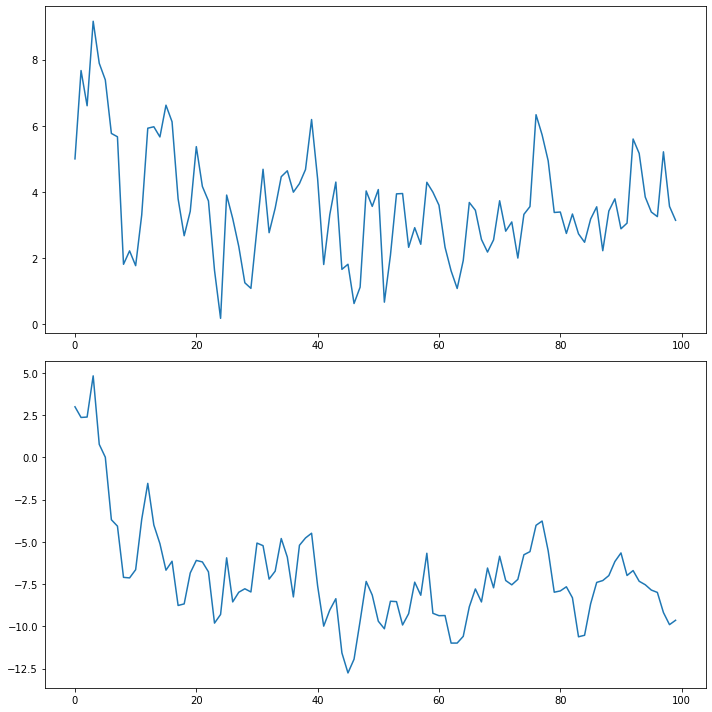

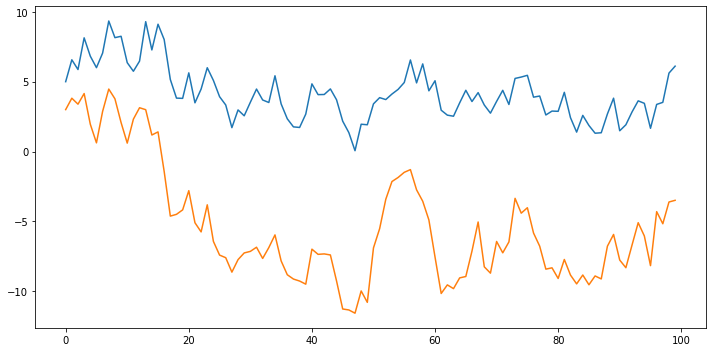

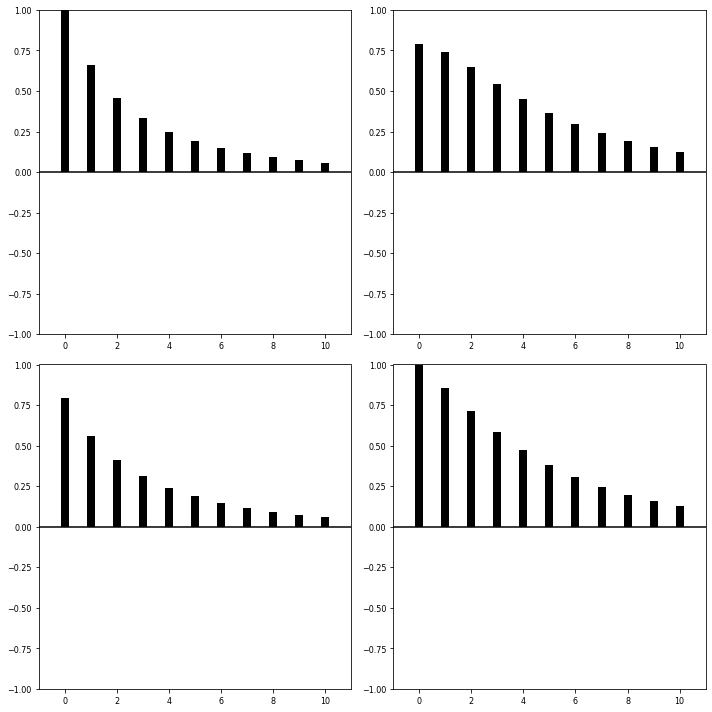

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 13, Mar, 2020
Time:                     23:32:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.325657
Nobs:                     99.0000    HQIC:                  0.232012
Log likelihood:          -283.284    FPE:                    1.18343
AIC:                     0.168377    Det(Omega_mle):         1.11484
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         5.094687         0.696008            7.320           0.000
L1.y1         0.185511         0.107543            1.725           0.085
L1.y2         0.319971         0.049597            6.451           0.000

Results for equation 

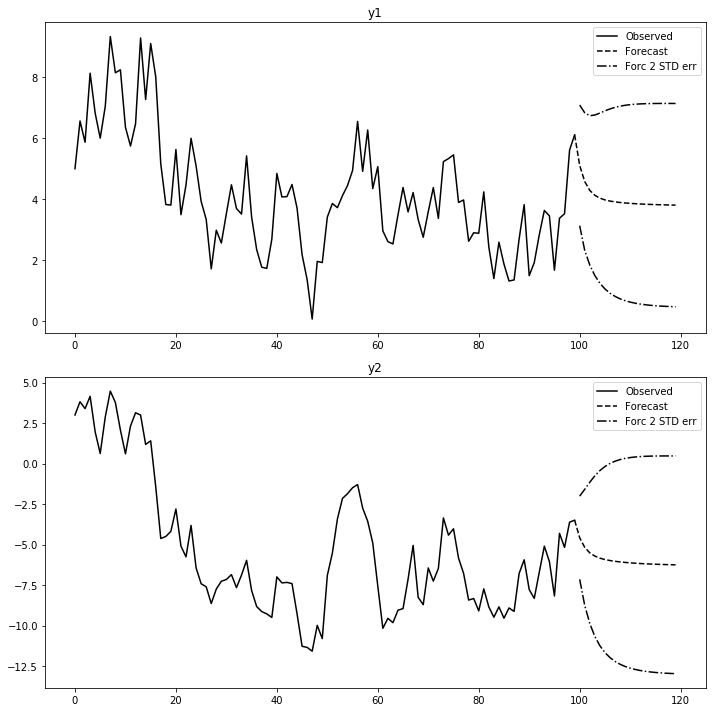

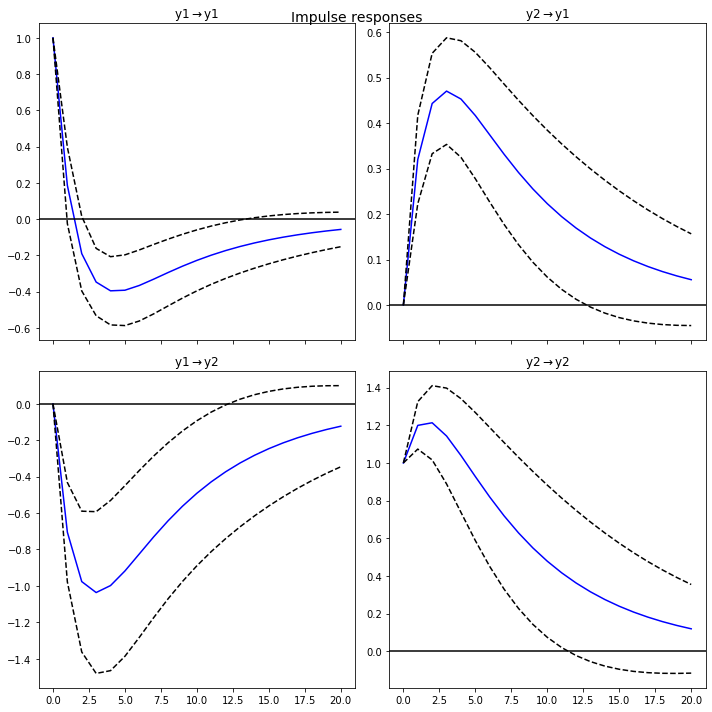

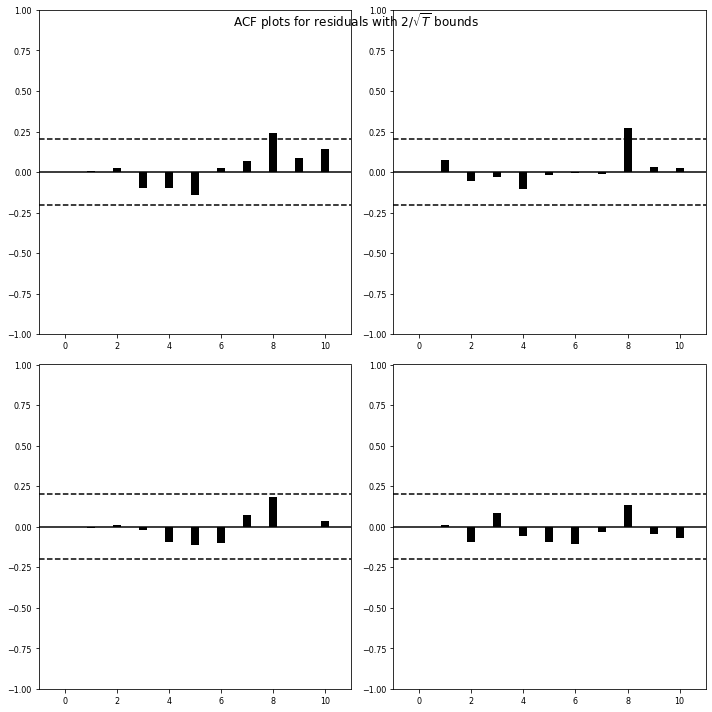

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm

# 차수 입력
intercept = np.array([5, 3])
matrix_A = np.array([[[0.2, 0.3], [-0.6, 1.1]]])
residual_covariance = np.array([[1, 0.8],[0.8, 2]])

# VAR 데이터 생성
fit = statsmodels.tsa.vector_ar.var_model.VARProcess(matrix_A, intercept, residual_covariance)
## 시뮬레이션 시각화1
simul_num = 100
fit.plotsim(steps=simul_num, seed=123)
plt.tight_layout()
plt.show()
## 시뮬레이션 시각화2
simul_num = 100
simul_values = statsmodels.tsa.vector_ar.util.varsim(fit.coefs, fit.intercept, fit.sigma_u, steps=simul_num)
plt.figure(figsize=(10,5))
plt.plot(simul_values)
plt.tight_layout()
plt.show()
## ACF 시각화
fit.plot_acorr()
plt.tight_layout()
plt.show()

# VAR 모형적합
fit = sm.tsa.VAR(simul_values).fit()
display(fit.summary())

# 예측 및 시각화
forecast_num = 20
pred_var = fit.forecast(fit.model.endog[-1:], steps=forecast_num)
pred_var_ci = fit.forecast_interval(fit.model.endog[-1:], steps=forecast_num)
fit.plot_forecast(forecast_num)
plt.tight_layout()
plt.show()

# 임펄스반응함수 추정
fit.irf(forecast_num).plot()
plt.tight_layout()
plt.show()

# 잔차진단
fit.plot_acorr()
plt.tight_layout()
plt.show()

### 실습: 거시경제 VAR 모형화 및 해석

- **데이터설명:** [링크](http://www.statsmodels.org/0.6.1/datasets/generated/macrodata.html)

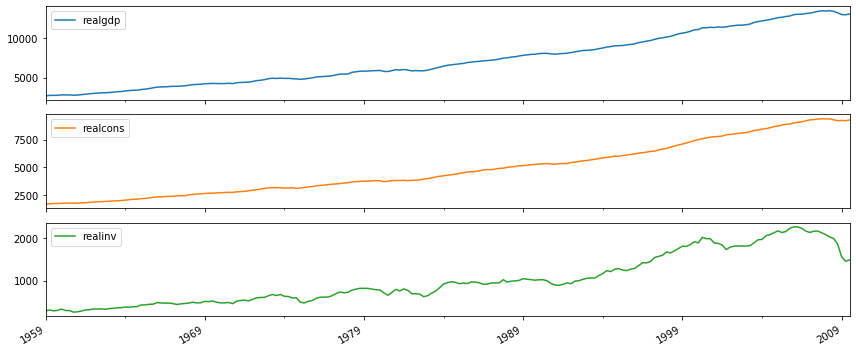

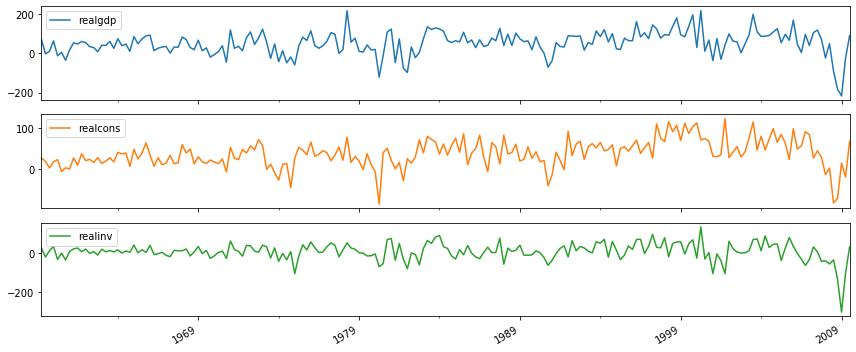

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 13, Mar, 2020
Time:                     23:32:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.5675
Nobs:                     200.000    HQIC:                   20.3614
Log likelihood:          -2852.49    FPE:                6.05346e+08
AIC:                      20.2212    Det(Omega_mle):     5.45987e+08
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              10.308143         6.425207            1.604           0.109
L1.realgdp         -0.394370         0.148481           -2.656           0.008
L1.realcons         1.185980         0.186610            6.355    

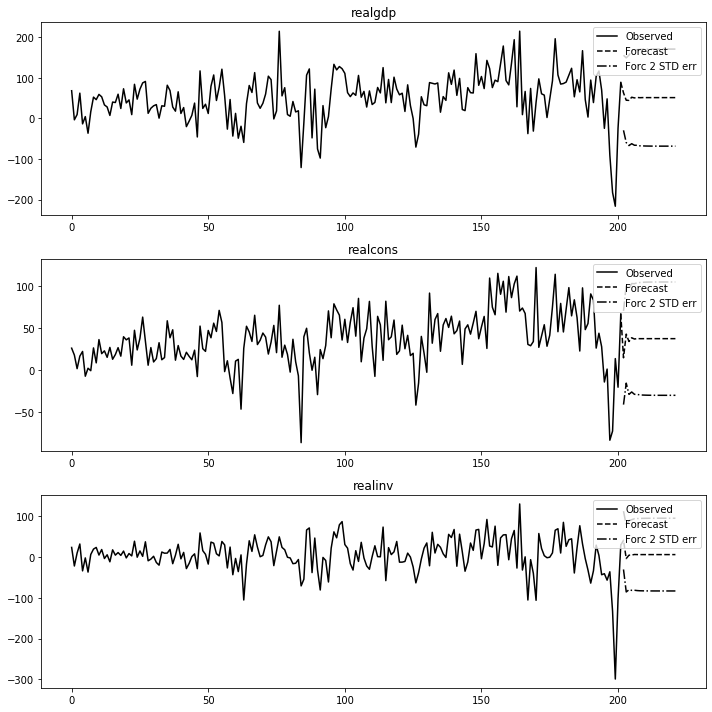

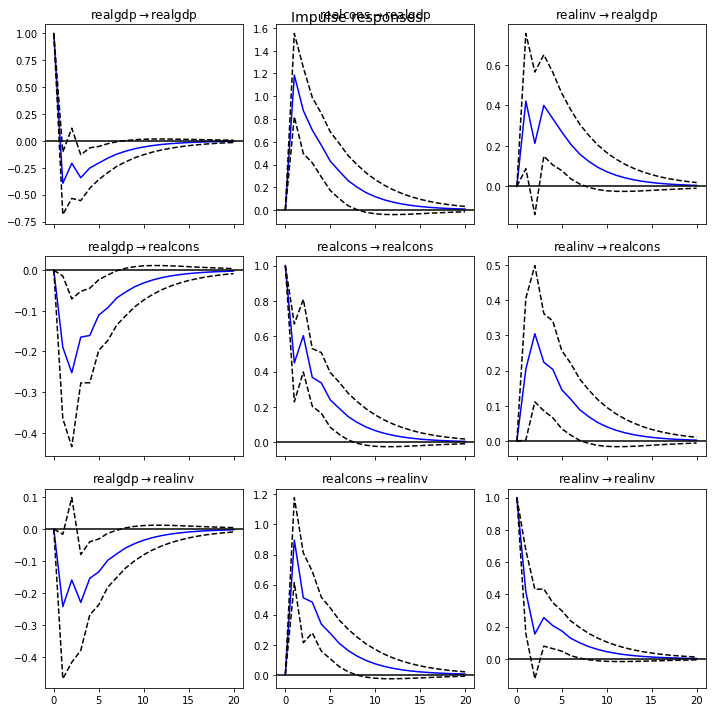

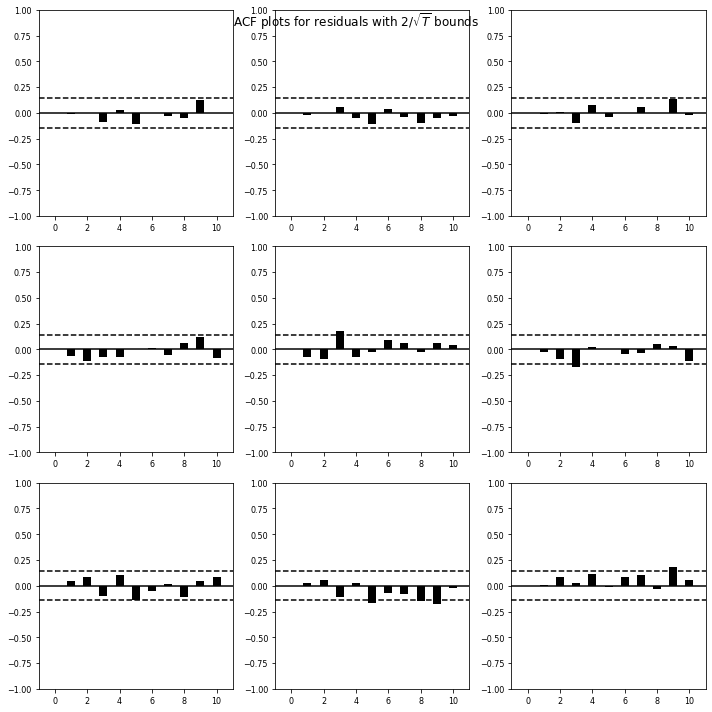

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm

# 데이터 로딩
raw = sm.datasets.macrodata.load_pandas().data
dates_info = raw[['year', 'quarter']].astype(int).astype(str)
raw.index = pd.DatetimeIndex(sm.tsa.datetools.dates_from_str(dates_info['year'] + 'Q' + dates_info['quarter']))
raw_use = raw.iloc[:,2:5]

# 데이터 시각화
raw_use.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

raw_use.diff(1).dropna().plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

# VAR 모형적합
raw_use_return = raw_use.diff(1).dropna()
fit = sm.tsa.VAR(raw_use_return).fit(maxlags=2)
display(fit.summary())

# # 예측 및 시각화
forecast_num = 20
# pred_var = fit.forecast(fit.model.endog[-1:], steps=forecast_num)
# pred_var_ci = fit.forecast_interval(fit.model.endog[-1:], steps=forecast_num)
fit.plot_forecast(forecast_num)
plt.tight_layout()
plt.show()

# 임펄스반응함수 추정
fit.irf(forecast_num).plot()
plt.tight_layout()
plt.show()

# 잔차진단
fit.plot_acorr()
plt.tight_layout()
plt.show()

## 그래인저 인과관계 모형(Granger Causality Model)

### 인과관계? 상관관계?

- **Spurious Regression**
> **"$X$와 $Y$가 관련(인과관계)이 없거나 논리적인 스토리가 없음에도 단순하게 상관성이 높다라는 공격"**
> - 지나치게 데이터에 집착할 필요도 없고, 데이터분석은 정말 어려운 작업  
> <center><img src='Image/Correlation_Causation_explained.jpg' width='500'></center>
> <center><img src='Image/Correlation_Causation_OMG.jpg' width='500'></center>

- **[Post Hoc Fallacy](https://en.wikipedia.org/wiki/Post_hoc_ergo_propter_hoc)**
> **"$X$ 다음에 $Y$가 일어났으므로 $X$가 $Y$의 원인이라는, 마치 시간순서가 인과관계를 담보할 것이라는 결과오류"**
> - 징크스: 머리를 염색했더니 시험점수가 100점이 나오더라?    
> - 오버피팅(Overfitting): 인과관계가 있는 데이터에서 샘플(Train) 데이터에 치우쳐버린 모델
> - Post Hoc Fallacy: 아무런 인과관계가 없는(상관관계는 높더라도) 데이터로 만든 모델  

### Granger Causality 이해

> **"[어떤 현상의 예측에 있어 다른 정보를 이용하는 것이 얼마나 유의미한지 나타내는 척도](https://en.wikipedia.org/wiki/Granger_causality)"**
> - **추론불가한 문제:** "닭이 먼저인가 달걀이 먼저인가?" (인과관계)  
> - **추론가능한 문제:** "닭과 달걀의 생성순서 별 서로의 영향력은 어떤가?" (Granger 인과관계)  
> - **필요성:**
    - 회귀분석에서 독립변수와 종속변수는 경제이론에 의해 이미 결정된 것으로 간주하고 인과관계 확인
    - 원인과 결과가 불분명한 경우 함수관계에 대한 명확한 결정은 현실적으로 어려움
> - **예시:**
    - 닭과 달걀의 생산량의 인과관계
    - 단기금리와 중기금리와의 인과관계
    - 강수량과 동물원방문객수의 인과관계
    - 급여인상액과 소비금액의 인과관계
    - 어떤 회사의 광고비지출액와 매출액의 인과관계
    - 강수량과 인터넷사용량의 인과관계
    - 어떤 광고캠페인의 수치형 설정조건과 클릭수와 인과관계
    

- **모형의 전재:** 과거의 사건은 현재의 사건을 유발할 수 있지만 미래의 사건은 현재의 사건을 유발할 수 없다  
    - **정상성:** 정상성 데이터를 가정하므로 독립변수($X$)와 종속변수($Y$)는 모두 정상성 상태여야 함 (비정상 데이터기반 결과는 오해석 여지가 많음)
    - **입력시차:** 입력변수로 시차(Lagged) 적용된 변수를 반영해야 하며, 예상되는 시차가 $N$이라면, $1$부터 $N$까지의 시차 모두를 입력변수로 사용해야 함
    - **최종시차:** 예상시차 $N$에 매우 민감하므로 적합한 길이를 선택해야 함 
        - 통상 연 환산빈도의 2~3배까지: 연별 자료시 2, 분기별 자료시 8, 월별 자료시 24)
        - $F$검정통계량의 유의한 변화에 의해 결정
    - **검정방향:** 독립변수와 종속변수의 양방향 관련성 비교가 필요하기에 총2회의 검정을 수행해야 함 
        - $X \implies Y$ 1회: $X$가 $Y$에 인과영향인지 테스트 ($\beta_j = 0$ 여부 확인, $\epsilon_{XY}$ 분산 감소정도 확인)
        \begin{align*}
        \text{Just use Y} && Y_{t} &= \mu_t + \displaystyle \sum_{i=1}^{\infty} \alpha_i Y_{t-i} + \epsilon_{Y} \\
        \text{Use X and Y} && Y_{t} &= \mu_t + \displaystyle \sum_{i=1}^{\infty} \alpha_i Y_{t-i} + \displaystyle \sum_{j=1}^{\infty} \beta_j X_{t-j} + \epsilon_{XY} \\
        \end{align*}
        - $Y \implies X$ 1회: $Y$가 $X$에 인과영향인지 테스트 ($\beta_j = 0$ 여부 확인, $\epsilon_{YX}$ 분산 감소정도 확인)
        \begin{align*}
        \text{Just use X} && X_{t} &= \mu_t + \displaystyle \sum_{i=1}^{\infty} \alpha_i X_{t-i} + \epsilon_{X} \\
        \text{Use X and Y} && X_{t} &= \mu_t + \displaystyle \sum_{i=1}^{\infty} \alpha_i X_{t-i} + \displaystyle \sum_{j=1}^{\infty} \beta_j Y_{t-j} + \epsilon_{YX} \\
        \end{align*}
    - **자동화가능성:** 여러가지 데이터에 일반화해서 자동화하기 어려움  
    - **주의사항:**  
        - 무조건적 인과관계를 단정할 수 없음
        - 시간 선후가 유의미한 맥락을 갖는 시계열에 적용할 수 있고, 시간선후 기간기준에 따라 Granger 인과관계가 있게 될 수 있음
        - 상관관계를 두고 인과관계가 없다는 증명으로 간단히 볼 수는 있지만, 보이지 않는 요소들도 고려되어야 확실함
    

- **Granger 인과관계 테스트**
    - **가설확인** 
        - **대중주장(귀무가설, Null Hypothesis, $H_0$):** 한 변수가 다른 변수를 예측하는데 도움이 되지 않는다
        - **나의주장(대립가설, Alternative Hypothesis, $H_1$):** 한 변수가 다른 변수를 예측하는데 도움이 된다
    - **의사결정(1회 검정)**
        - **p-value >= 내기준(ex. 0.05):** 내가 수집한(분석한) 데이터는 대중주장과 유사하니 대중주장 참 & 나의주장 거짓
            > **수집한(분석한) 데이터는 한 변수가 다른 변수를 예측하는데 도움되지 않는다**
        - **p-value < 내기준(ex. 0.05):** 내가 수집한(분석한) 데이터는 대중주장을 벗어나니 대중주장 거짓 & 나의주장 참
            > **수집한(분석한) 데이터는 한 변수가 다른 변수를 예측하는데 도움된다**  
    - **의사결정(2회 검정 비교)**
        - **"$Y$ lags로만 $Y$의 데이터를 선형회귀한 것의 예측력(p-value)" > "$X$ lags + $Y$ lags로 $Y$의 데이터를 선형회귀한 것의 예측력(p-value)"**    
            > **수집한(분석한) 데이터는 $X$변수가 $Y$변수를 예측하는데 도움되지 않는다**
        - **"$X$ lags + $Y$ lags로 $Y$의 데이터를 선형회귀한 것의 예측력(p-value)" > "$Y$ lags로만 $Y$의 데이터를 선형회귀한 것의 예측력(p-value)"**    
            > **수집한(분석한) 데이터는 $X$변수가 $Y$변수를 예측하는데 도움된다**    
    - **결과조합**
        - "$X$가 $Y$에 인과영향을 준다" + "$Y$는 $X$에 인과영향을 주지 않는다"  
        : **$X$가 $Y$에 선행한다고 볼 수 있기에, $X$가 $Y$의 인과요인이 될 가능성이 높음**
        
        - "$Y$가 $X$에 인과영향을 준다" + "$X$는 $Y$에 인과영향을 주지 않는다"  
        : **$Y$가 $X$에 선행한다고 볼 수 있기에, $Y$가 $X$의 인과요인이 될 가능성이 높음**
        
        - "$X$가 $Y$에 인과영향을 준다" + "$Y$도 $X$에 인과영향을 준다"  
        : **쌍방으로 Granger Causality가 성립하는 경우로 이 경우 제3의 외부변수(Exogenous Variable)가 영향을 공통으로 주었을 가능성이 높음**  
        : **제3의 외부변수(Exogenous Variable)를 알아내던가 포기하던가 해야하며, $VAR$모형을 사용해야 할 수 있음(Granger Causality도 $VAR$모형 중 하나)**  
        
        - "$X$가 $Y$에 인과영향을 주지 않는다" + "$Y$도 $X$에 인과영향을 주지 않는다"    
        : **두 변수가 서로 인과영향을 주지 않는다고 볼 수도 있지만 단언은 어려움**  
        : **$ARIMA$모형으로 추가 확인이 가능할 수 있음**  
        : **입력되는 최종 시차에 따라 달라질 수 있으므로 시차에 따른 해석을 달리 할 수도 있음(사람의 경험과 판단이 개입되어야 함)**  

### 실습: 닭과 달걀의 생산량을 통한 Granger 인과관계 이해

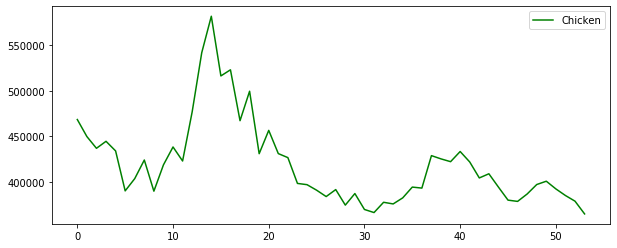

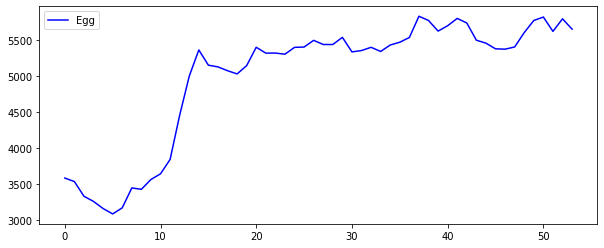

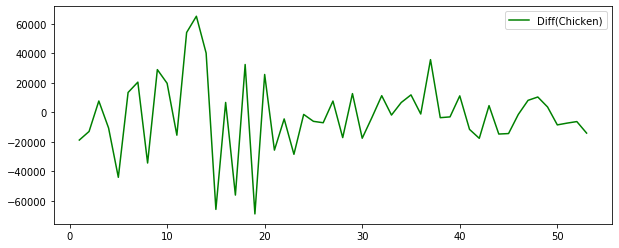

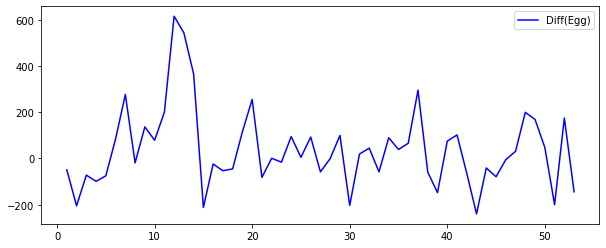


[Egg -> Chicken]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3694 , p=0.0023  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=11.0043 , p=0.0009  , df=1
likelihood ratio test: chi2=9.9819  , p=0.0016  , df=1
parameter F test:         F=10.3694 , p=0.0023  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9196  , p=0.0268  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=8.6913  , p=0.0130  , df=2
likelihood ratio test: chi2=8.0254  , p=0.0181  , df=2
parameter F test:         F=3.9196  , p=0.0268  , df_denom=46, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9318  , p=0.0441  , df_denom=43, df_num=3
ssr based chi2 test:   chi2=10.2270 , p=0.0167  , df=3
likelihood ratio test: chi2=9.3049  , p=0.0255  , df=3
parameter F test:         F=2.9318  , p=0.0441  , df_denom=43, df_num=3

[Chicken -> Egg]

Granger Causality
number of lags (no zero) 1
ssr based F test: 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 데이터 로딩
location = './Data/ChickenEggProduction/Chicken_Egg_Production.txt'
raw_all = pd.read_csv(location, sep='\t')
raw_all.head()

# 데이터 시각화
plt.figure(figsize=(10,4))
plt.plot(raw_all['Chicken'], 'g', label='Chicken')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(raw_all['Egg'], 'b', label='Egg')
plt.legend()
plt.show()

# 정상성 변환 시각화
plt.figure(figsize=(10,4))
plt.plot(raw_all['Chicken'].diff(1), 'g', label='Diff(Chicken)')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(raw_all['Egg'].diff(1), 'b', label='Diff(Egg)')
plt.legend()
plt.show()

# Granger Causality 테스트
print('\n[Egg -> Chicken]')
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw_all.diff(1).dropna().iloc[:,1:].values, maxlag=3, verbose=True)
print('\n[Chicken -> Egg]')
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw_all.diff(1).dropna().iloc[:,[2,1]].values, maxlag=3, verbose=True)

# 의사결정
# 닭이 달걀을 낳으면 그 수는 약 3년후까지 닭의 수에 영향을 준다
# 닭의 수가 많아진다고해서 달걀을 많이 낳지는 않는다
# 달걀 -> 닭 (Granger Causality)

### 실습: 삼성전자와 삼성전자 우선주 Granger 인과관계 이해

In [21]:
!pip install pandas-datareader

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


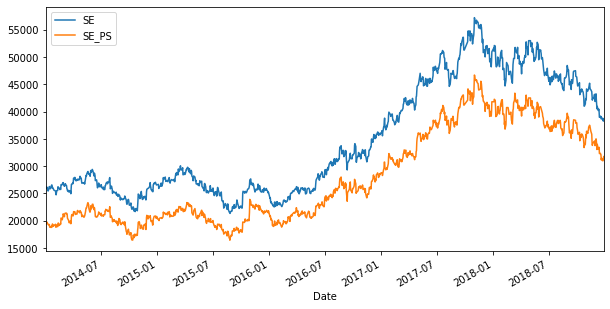

Y1_order:  1 Y2_order:  1

[삼성전자우 -> 삼성전자]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8613  , p=0.0496  , df_denom=1216, df_num=1
ssr based chi2 test:   chi2=3.8708  , p=0.0491  , df=1
likelihood ratio test: chi2=3.8647  , p=0.0493  , df=1
parameter F test:         F=3.8613  , p=0.0496  , df_denom=1216, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5263  , p=0.0297  , df_denom=1213, df_num=2
ssr based chi2 test:   chi2=7.0818  , p=0.0290  , df=2
likelihood ratio test: chi2=7.0613  , p=0.0293  , df=2
parameter F test:         F=3.5263  , p=0.0297  , df_denom=1213, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6935  , p=0.0448  , df_denom=1210, df_num=3
ssr based chi2 test:   chi2=8.1273  , p=0.0435  , df=3
likelihood ratio test: chi2=8.1002  , p=0.0440  , df=3
parameter F test:         F=2.6935  , p=0.0448  , df_denom=1210, df_num=3

Granger Causality
number of lags (no zero) 4

In [22]:
# 데이터 로딩
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 12, 31)
raw1 = web.DataReader("005930.KS", 'yahoo', start, end)
raw2 = web.DataReader("005935.KS", 'yahoo', start, end)
# raw2 = web.DataReader("009150.KS", 'yahoo', start, end)

# 데이터 시각화
raw = pd.concat([raw1.Close, raw2.Close], axis=1).dropna()
raw.columns = ["SE", "SE_PS"]
raw.plot(figsize=(10,5))
plt.show()

# 비정상성 차수 추론
target = raw.SE.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
target = raw.SE_PS.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)

# Granger Causality 테스트
print('\n[삼성전자우 -> 삼성전자]')
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag=4, verbose=True)
print('\n[삼성전자 -> 삼성전자우]')
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:,[1,0]].values, maxlag=4, verbose=True)

# 의사결정

## 공적분 모형(Cointegration Model)

- **공적분 상태(Cointegration):** 두 비정상성 시계열을 선형조합(Linear Combination)하여 생성한 시계열의 적분(Integration) 차수가 낮아지거나 정상상태가 되는 경우

- **공적분 벡터(Cointegration Vector):** 이러한 선형 조합을 만드는 값

- **공적분 시계열(Cointegration Time Series):**
    - 서로 상관관계를 가지지 않음에도 불구하고 장기적으로 같은 방향으로 움직이는 특성
    - 술취한 사람이 개를 끈에 묶어 다니는 경우, 사람과 개는 각자 아무런 상관관계가 없이 움직이지만 서로 너무 멀어지지는 않는 것과 유사
    - 페어 트레이딩 (Pair Trading), 통계적 차익거래 (Statistical Arbitrage) 등의 매매전략에 응용 가능
   
\begin{align*}
\text{Each Integration Order} && Y_1 &\sim I(d_1) \\
&& Y_2 &\sim I(d_2) \\
\text{Cointegration Vector} && \alpha &= [\alpha_1, \alpha_2] \\
\text{where} && \alpha_1 x_1 &+ \alpha_2 x_2 \sim I(b), \;\; b < d_1, \;\; b < d_2 \\
\end{align*}

- **공적분 판별:**
> **Engle-Granger's Representation Theorem (Vector Error Correction Model)**
> \begin{align*}
\text{두 시계열 $Y_{1t} \sim I(1)$, $Y_{2t} \sim I(1)$이 공적분}
& \iff \Delta Y_{2t} = \gamma_1 z_{t-1}  + \sum_{i=1}^K \psi_{1,i} \Delta Y_{1t-i} + \sum_{i=1}^L \psi_{2,i} \Delta Y_{2t-i} + e_{t} \\
& \text{($z_t$는 $Y_{2t}$를 종속변수로 $Y_{1t}$를 독립변수로 회귀분석하여 만들어진 잔차)} \\
\end{align*}
> - $\Delta Y_{1t}$와 $\Delta Y_{2t}$는 항상 정상성 시계열
> - 위 식이 성립하려면 $z_t$와 $e_t$가 정상성 시계열이어야 함 
    1) $Y_{2t}$를 종속변수로 $Y_{1t}$를 독립변수로 회귀분석하여 만들어진 잔차 $z_t$가 정상성 시계열인지를 확인 
    2) 변환된 변수들의 $VECM$ 회귀 분석의 잔차 $e_t$가 정상성 시계열인지를 확인 

### 실습: Cointegration 데이터 생성 및 이해

\begin{align*}
\text{Example of Cointegration} \\
\text{Y1: Random Walk with I(1)} && Y_{1t} &= Y_{1t-1} + e_{1t} \\
\text{Y2: Random Walk with I(1)} && Y_{2t} &= 0.6 Y_{1t} + e_{2t} \\
\text{Y: Stationary Time Series} && Y &= 0.6 Y_{1t} - Y_{2t} \\
\end{align*}

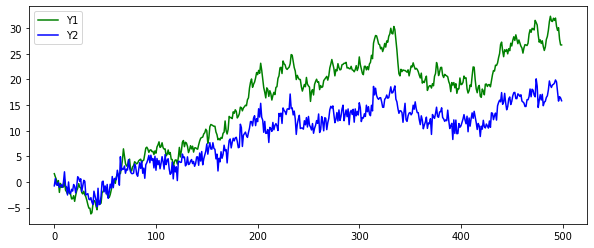

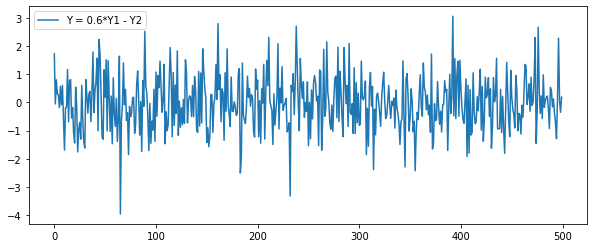

,output
statistics,-22.680907
p-value,0.000000


In [23]:
# 데이터 생성
np.random.seed(1)
Y1 = np.random.randn(500).cumsum()
Y2 = 0.6 * Y1 + np.random.randn(500)
Y = 0.6 * Y1 - Y2

# 시각화
plt.figure(figsize=(10,4))
plt.plot(Y1, 'g', label='Y1')
plt.plot(Y2, 'b', label='Y2')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(Y, label='Y = 0.6*Y1 - Y2')
plt.legend()
plt.show()

# VECM 공적분 확인
coint_result = sm.tsa.coint(Y1, Y2)
pd.DataFrame([coint_result[0], coint_result[1]], index=['statistics', 'p-value'], columns=['output'])

### 실습: 페어 트레이딩 Cointegration 모형화 및 해석

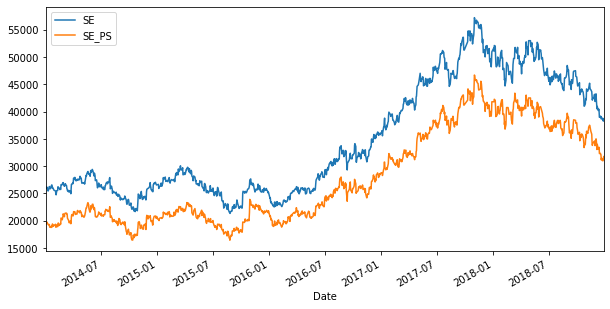

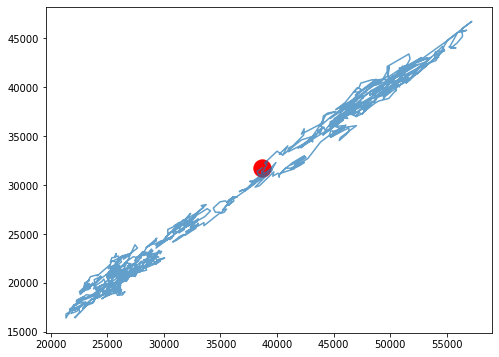

Y1_order:  1 Y2_order:  1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SE   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.295e+05
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:33:27   Log-Likelihood:                -10165.
No. Observations:                1221   AIC:                         2.033e+04
Df Residuals:                    1219   BIC:                         2.034e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        915.1881     97.943      9.344      0.000     723.033    1107.344
SE_PS          1.2147      0.003    359.877      0.000       1.208       1.221
==============================================================================
Omnibus:                       11.477   Durbin-Watson:                   0.124
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.735
Skew:                          -0.189   Prob(JB):                      0.00467
Kurtosis:                       2.738   Cond. No.                     9.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

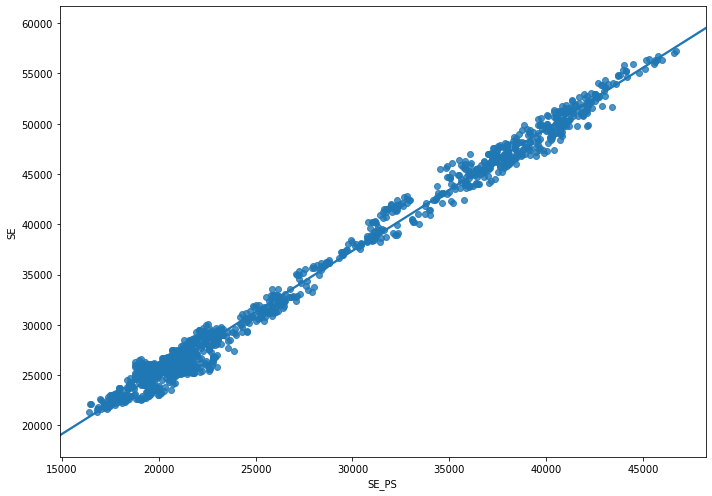

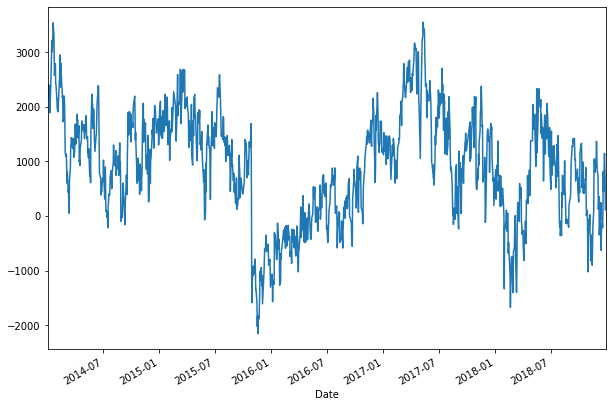

Test Statistics        -3.742838
p-value                 0.003549
Used Lag                9.000000
Used Observations    1211.000000
dtype: float64

,output
statistics,-3.743068
p-value,0.016116


In [24]:
# 데이터 로딩
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 12, 31)
raw1 = web.DataReader("005930.KS", 'yahoo', start, end)
raw2 = web.DataReader("005935.KS", 'yahoo', start, end)
# raw2 = web.DataReader("009150.KS", 'yahoo', start, end)

# 데이터 시각화
## 시계열 움직임
raw = pd.concat([raw1.Close, raw2.Close], axis=1).dropna()
raw.columns = ["SE", "SE_PS"]
raw.plot(figsize=(10,5))
plt.show()

## 비교 움직임
plt.figure(figsize=(8,6))
plt.plot(raw.SE, raw.SE_PS, alpha=0.7)
plt.scatter(raw.SE.values[-1:], raw.SE_PS.values[-1:], c="r", s=300)
plt.show()

# 비정상성 차수 추론
target = raw.SE.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
target = raw.SE_PS.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)
    
# 회귀분석 적합
## 모델링
Y = raw.SE
X = raw.SE_PS
X = sm.add_constant(X)
fit = sm.OLS(Y, X).fit()
display(fit.summary())

## 회귀분석 시각화
import seaborn as sns
plt.figure(figsize=(10,7))
sns.regplot(x="SE_PS", y="SE", data=raw)
plt.tight_layout()
plt.show()

# 공적분 시계열 시각화
Y_integ = raw.SE - fit.params[1]*raw.SE_PS
plt.figure(figsize=(10,7))
Y_integ.plot()
plt.show()

# 공적분 시계열 비정상성 테스트
target = fit.resid
display(pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# VECM 공적분 테스트
coint_result = sm.tsa.coint(raw.SE, raw.SE_PS)
pd.DataFrame([coint_result[0], coint_result[1]], index=['statistics', 'p-value'], columns=['output'])